# run wind-up analysis on the open source smarteole data
Dataset citation:
Thomas Duc, & Eric Simley. (2022). SMARTEOLE Wind Farm Control open dataset (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7342466

See [wind-up uplift validation methodology.pdf](https://github.com/resgroup/wind-up/blob/main/docs/wind-up%20uplift%20validation%20methodology.pdf) for a description of the calculation methodology.

In [1]:
import sys
from pathlib import Path

import pandas as pd

from wind_up.constants import PROJECTROOT_DIR
from wind_up.interface import AssessmentInputs
from wind_up.main_analysis import run_wind_up_analysis
from wind_up.models import PlotConfig
from wind_up.reanalysis_data import ReanalysisDataset

sys.path.append(str(PROJECTROOT_DIR))
from examples.helpers import download_zenodo_data

## configure logger so wind-up log messages are displayed in this notebook

In [2]:
import logging
import re

from IPython.display import Markdown, display

logging.basicConfig(format="%(message)s", level=logging.INFO)


class NotebookHandler(logging.Handler):
    def emit(self, record):  # noqa ANN001
        message = self.format(record)
        # Replace newline characters with <br> tags
        message = re.sub(r"\n", "<br>", message)
        display(Markdown(message))


logger = logging.getLogger()
logger.handlers = []  # Clear existing handlers to avoid duplication
logger.addHandler(NotebookHandler())

## download the smarteole data from zenodo

In [3]:
from examples.smarteole_example import CACHE_DIR, ZIP_FILENAME

download_zenodo_data(record_id="7342466", output_dir=CACHE_DIR, filenames={ZIP_FILENAME}, cache_overwrite=True)

Beginning file download from Zenodo: SMARTEOLE-WFC-open-dataset.zip...

## organize wind farm scada data as a pandas dataframe

In [4]:
import warnings

from scipy.stats._axis_nan_policy import SmallSampleWarning

from examples.smarteole_example import ANALYSIS_TIMEBASE_S, CACHE_SUBDIR, unpack_smarteole_scada

warnings.filterwarnings("ignore", category=SmallSampleWarning)

CACHE_SUBDIR.mkdir(exist_ok=True, parents=True)
scada_df = unpack_smarteole_scada(ANALYSIS_TIMEBASE_S)
scada_df.head()

TurbineName  ActivePowerMean  ActivePowerSD  \
TimeStamp_StartFormat                                               
2020-02-17 16:30:00          SMV1        2017.8566        57.0837   
2020-02-17 16:40:00          SMV1        1946.2472        91.7614   
2020-02-17 16:50:00          SMV1        1946.5069        98.3934   
2020-02-17 17:00:00          SMV1        1828.9365       139.5910   
2020-02-17 17:10:00          SMV1        1751.7035       170.2128   

                       WindSpeedMean  WindSpeedSD  YawAngleMean  YawAngleMin  \
TimeStamp_StartFormat                                                          
2020-02-17 16:30:00          13.6164       1.2411    247.884662      239.930   
2020-02-17 16:40:00          13.0139       1.0178    259.686000      259.686   
2020-02-17 16:50:00          12.5818       0.9482    259.686000      259.686   
2020-02-17 17:00:00          11.6641       0.9244    252.924035      249.808   
2020-02-17 17:10:00          11.3144       1.0116    249.808000      249.808   

                       YawAngleMax  PitchAngleMean  GenRpmMean  AmbientTemp  \
TimeStamp_StartFormat                                                         
2020-02-17 16:30:00        259.686          6.0648   1800.5394      11.6191   
2020-02-17 16:40:00        259.686          3.5153   1798.7652      11.5493   
2020-02-17 16:50:00        259.686          2.1367   1799.5171      11.4929   
2020-02-17 17:00:00        259.686          0.8526   1799.4533      11.4735   
2020-02-17 17:10:00        249.808          0.2404   1799.2136      11.3937   

                       ShutdownDuration  
TimeStamp_StartFormat                    
2020-02-17 16:30:00                   0  
2020-02-17 16:40:00                   0  
2020-02-17 16:50:00                   0  
2020-02-17 17:00:00                   0  
2020-02-17 17:10:00                   0

## organize wind farm meta data (such as lat long) as a pandas dataframe

In [5]:
from examples.smarteole_example import unpack_smarteole_metadata

metadata_df = unpack_smarteole_metadata(ANALYSIS_TIMEBASE_S)
metadata_df.head()

Name  Latitude  Longitude TimeZone  TimeSpanMinutes TimeFormat
0  SMV1  49.84975    2.80194      UTC             10.0      Start
1  SMV2  49.84661    2.80150      UTC             10.0      Start
2  SMV3  49.84347    2.80162      UTC             10.0      Start
3  SMV4  49.84033    2.80122      UTC             10.0      Start
4  SMV5  49.83719    2.80080      UTC             10.0      Start

## organize toggle data as a pandas dataframe
toggle data is data from the controller running the toggle test, in this case a wake steering controller

In [6]:
from examples.smarteole_example import unpack_smarteole_toggle_data

toggle_df = unpack_smarteole_toggle_data(ANALYSIS_TIMEBASE_S)
toggle_df.head()

toggle_on  toggle_off  yaw_offset_command
TimeStamp_StartFormat                                               
2020-02-17 16:30:00+00:00      False        True                 0.0
2020-02-17 16:40:00+00:00      False        True                 0.0
2020-02-17 16:50:00+00:00      False        True                 0.0
2020-02-17 17:00:00+00:00       True       False                 0.0
2020-02-17 17:10:00+00:00       True       False                 0.0

## merge the yaw offset command data into the scada data
this is not stricty necessary but means the yaw offset command data is available for plotting during analysis

In [7]:
toggle_df_no_tz = toggle_df.copy()
toggle_df_no_tz.index = toggle_df_no_tz.index.tz_localize(None)
scada_df = scada_df.merge(toggle_df_no_tz["yaw_offset_command"], left_index=True, right_index=True, how="left")
scada_df["yaw_offset_command"] = scada_df["yaw_offset_command"].where(scada_df["TurbineName"] == "SMV6", 0)
del toggle_df_no_tz
scada_df[["TurbineName", "ActivePowerMean", "yaw_offset_command"]].head()

TurbineName  ActivePowerMean  yaw_offset_command
TimeStamp_StartFormat                                                 
2020-02-17 16:30:00          SMV1        2017.8566                 0.0
2020-02-17 16:40:00          SMV1        1946.2472                 0.0
2020-02-17 16:50:00          SMV1        1946.5069                 0.0
2020-02-17 17:00:00          SMV1        1828.9365                 0.0
2020-02-17 17:10:00          SMV1        1751.7035                 0.0

example data with yaw_offset_command > 0

In [8]:
scada_df.loc[
    (scada_df["TurbineName"] == "SMV6") & (scada_df.index > pd.Timestamp("2020-02-18 19:00")),
    ["TurbineName", "ActivePowerMean", "yaw_offset_command"],
].head()

TurbineName  ActivePowerMean  yaw_offset_command
TimeStamp_StartFormat                                                 
2020-02-18 19:10:00          SMV6        1164.0942             19.8272
2020-02-18 19:20:00          SMV6        1533.1757             18.9361
2020-02-18 19:30:00          SMV6        1734.7691             12.5647
2020-02-18 19:40:00          SMV6        1860.2886              9.6538
2020-02-18 19:50:00          SMV6        1778.6030              9.8110

## get nearby reanalysis data
Can be from any source. ERA5T is generally very helpful for wind-up analysis

In [9]:
reanalysis_dataset = ReanalysisDataset(
    id="ERA5T_50.00N_2.75E_100m_1hr",
    data=pd.read_parquet(Path("smarteole_data") / "ERA5T_50.00N_2.75E_100m_1hr_20200201_20200531.parquet"),
)
reanalysis_dataset.data.head()

10_m_hws_mean_mps  10_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                       
2020-02-01 00:00:00+00:00               6.29                     203.1   
2020-02-01 01:00:00+00:00               6.57                     204.3   
2020-02-01 02:00:00+00:00               6.54                     209.5   
2020-02-01 03:00:00+00:00               6.29                     216.2   
2020-02-01 04:00:00+00:00               6.06                     220.8   

                           100_m_hws_mean_mps  100_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00               10.33                      206.6   
2020-02-01 01:00:00+00:00               10.80                      207.4   
2020-02-01 02:00:00+00:00               10.69                      212.1   
2020-02-01 03:00:00+00:00               10.25                      218.9   
2020-02-01 04:00:00+00:00                9.81                      223.6   

                           2_m_temp_mean_deg-c  2_m_dew_point_temp_deg-c  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                 11.6                       9.8   
2020-02-01 01:00:00+00:00                 11.6                      10.2   
2020-02-01 02:00:00+00:00                 11.6                      10.7   
2020-02-01 03:00:00+00:00                 11.6                      11.1   
2020-02-01 04:00:00+00:00                 11.6                      11.3   

                           2_m_rh_mean_%  0_m_pres_mean_pa  \
datetime_start_utc                                           
2020-02-01 00:00:00+00:00           88.9           99621.8   
2020-02-01 01:00:00+00:00           91.2           99547.5   
2020-02-01 02:00:00+00:00           93.9           99486.1   
2020-02-01 03:00:00+00:00           96.4           99432.0   
2020-02-01 04:00:00+00:00           97.9           99341.0   

                           sea_level_pres_mean_pa  boundary_layer_height_m  \
datetime_start_utc                                                           
2020-02-01 00:00:00+00:00                100815.6                    834.2   
2020-02-01 01:00:00+00:00                100739.8                    813.0   
2020-02-01 02:00:00+00:00                100678.0                    808.8   
2020-02-01 03:00:00+00:00                100623.2                    823.8   
2020-02-01 04:00:00+00:00                100530.8                    788.9   

                           total_cloud_cover_%  \
datetime_start_utc                               
2020-02-01 00:00:00+00:00                100.0   
2020-02-01 01:00:00+00:00                100.0   
2020-02-01 02:00:00+00:00                100.0   
2020-02-01 03:00:00+00:00                100.0   
2020-02-01 04:00:00+00:00                100.0   

                           instantaneous_surface_sensible_heat_flux_wpm2  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                                         30.138   
2020-02-01 01:00:00+00:00                                         33.538   
2020-02-01 02:00:00+00:00                                         32.996   
2020-02-01 03:00:00+00:00                                         27.442   
2020-02-01 04:00:00+00:00                                         22.671   

                           friction_velocity_mps  cloud_base_height_m  \
datetime_start_utc                                                      
2020-02-01 00:00:00+00:00               0.441049                204.6   
2020-02-01 01:00:00+00:00               0.435240                 30.8   
2020-02-01 02:00:00+00:00               0.424339                 30.8   
2020-02-01 03:00:00+00:00               0.411508                 30.8   
2020-02-01 04:00:00+00:00               0.396724                 30.8   

                           surface_solar_radiation_downwards_wpm

## define the wind-up analysis configuration

In [10]:
from examples.smarteole_example import define_smarteole_example_config

cfg = define_smarteole_example_config()
plot_cfg = PlotConfig(show_plots=True, save_plots=False, skip_per_turbine_plots=True, plots_dir=cfg.out_dir / "plots")

loaded WindUpConfig assessment_name: smarteole_example

toggle analysis period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

long term period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

detrend period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

## create the assessment inputs object
This object bundles everything needed to run the wind-up analysis
In particular the wind farm SCADA data is filtered and northed.
A wind speed estimate for each turbine is also derived mainly from power so that the anemometer data is used as little as possible.  

running wind_up analysis for smarteole_example

running load_smart_scada_and_md_from_file for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00

loaded 7 turbines, 0.3 years per turbine

finished load_smart_scada_and_md for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00

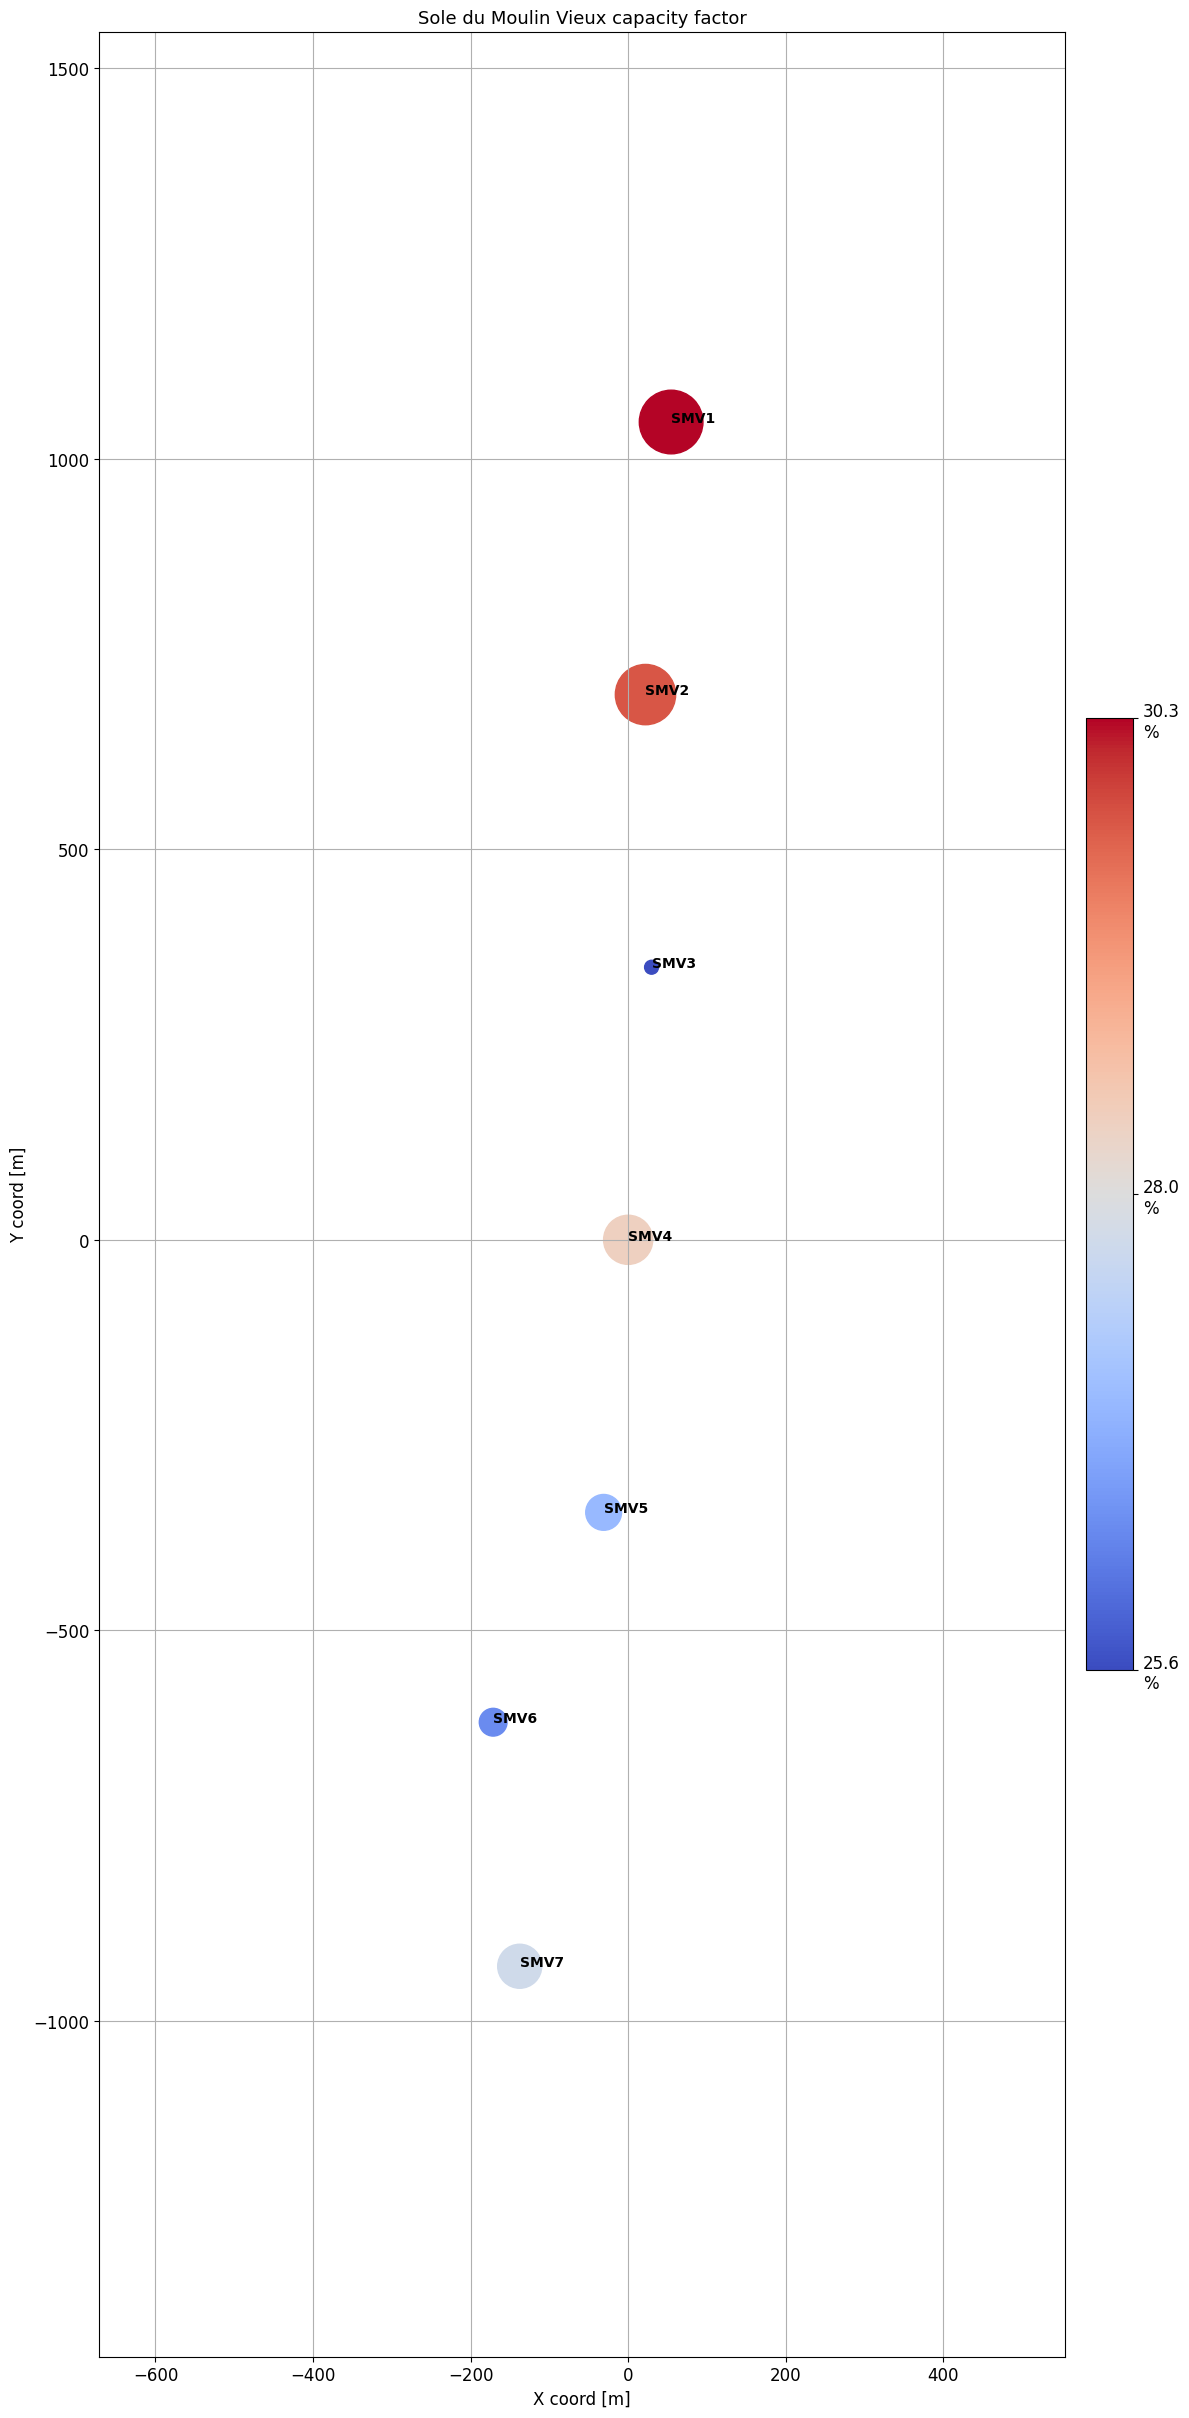

average capacity factor: 27.9%

top 3 capacity factor [%]:<br>+------+------+<br>| SMV1 | 30.3 |<br>| SMV2 | 29.8 |<br>| SMV4 | 28.3 |<br>+------+------+

bottom 3 capacity factor [%]:<br>+------+------+<br>| SMV3 | 25.6 |<br>| SMV6 | 26.3 |<br>| SMV5 | 26.9 |<br>+------+------+

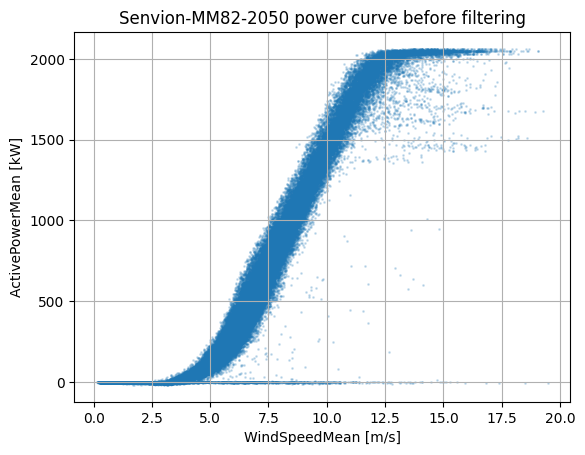

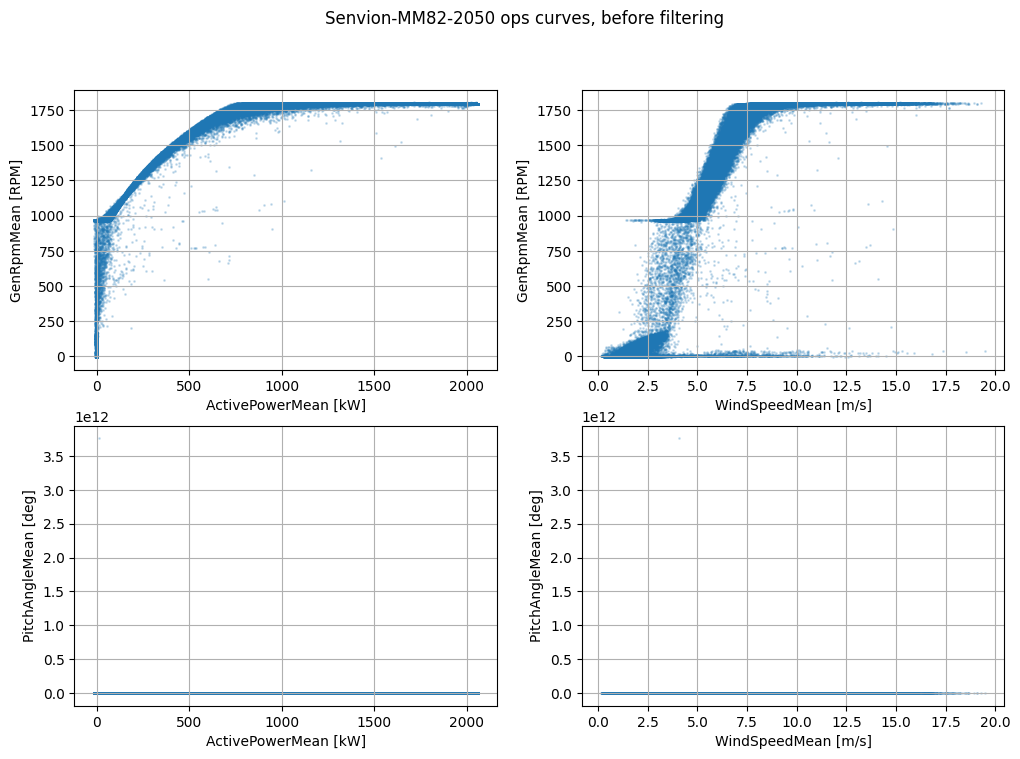

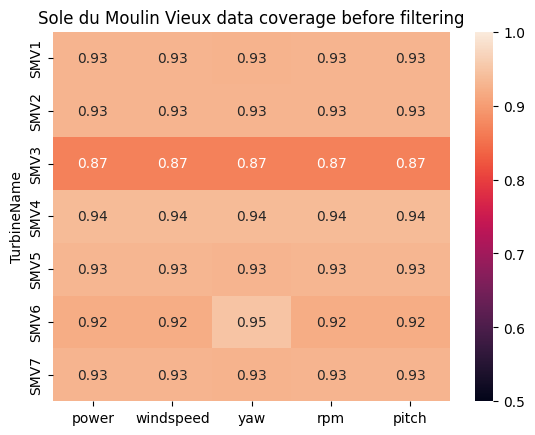

7855 rows [8.0%] of power data is missing before filtering

filter_stuck_data set 0 rows [0.0%] to NA

filter_bad_pw_ws set 0 rows [0.0%] to NA

rows with PitchAngleMean lt -180: 0

rows with PitchAngleMean ge 180: 1

wrapped PitchAngleMean to -180-180

filter_wrong_yaw set 26471 rows [27.0%] to NA yaw Min & Max because of bad YawAngleMin/Max values

filter_wrong_yaw set 232 rows [0.2%] to NA yaw because of YawAngleMean appears to be wrong

filter_exclusions set 0 rows [0.0%] to NA

filter_yaw_exclusions set 0 rows [0.0%] to NA yaw

filter_downtime set 0 rows [0.0%] to NA

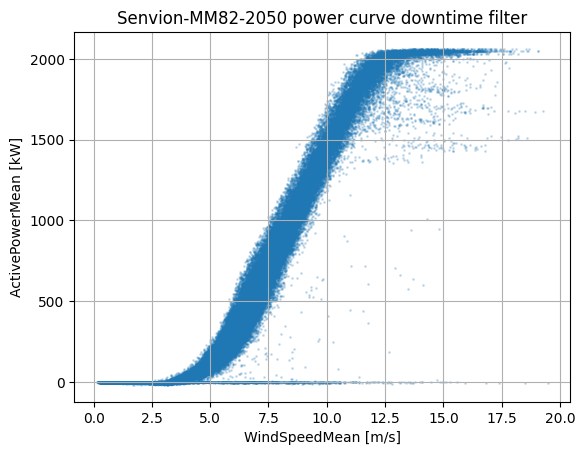

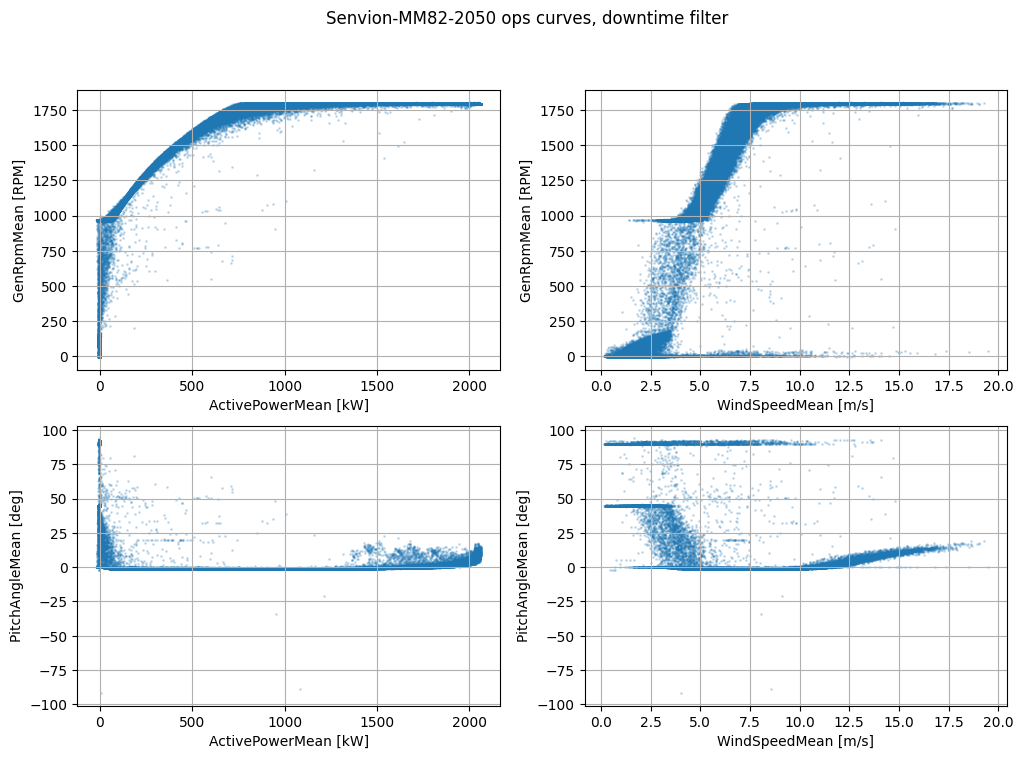

filter_missing_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are NA

filter_rpm_and_pt set 13598 rows [13.9%] to NA because of rpm or pitch are out of range

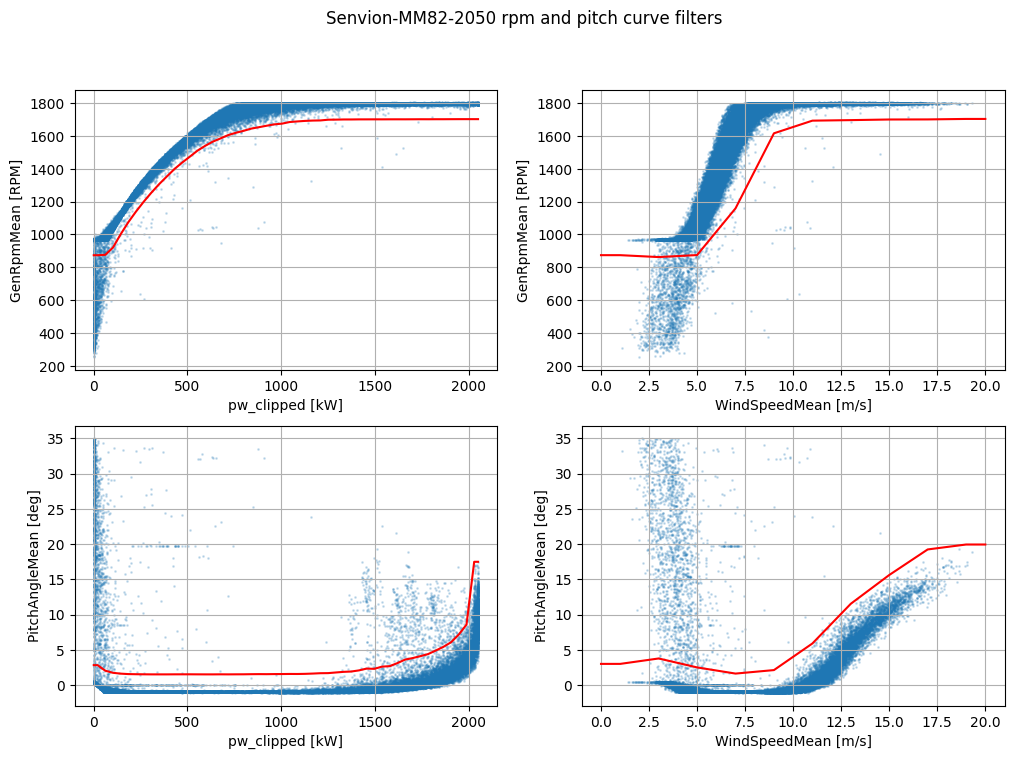

filter_rpm_and_pt set 2663 rows [2.7%] to NA because of rpm or pitch curve filtering

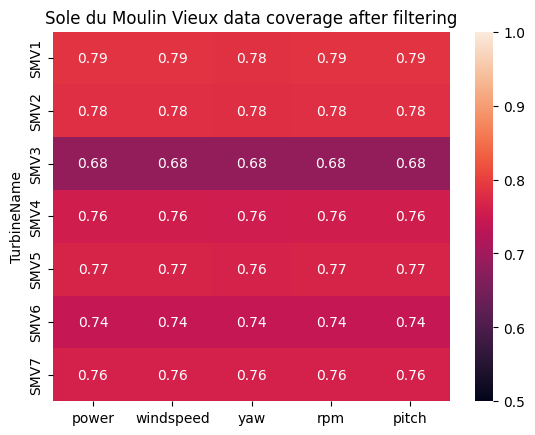

24116 rows [24.6%] of power data is missing after filtering

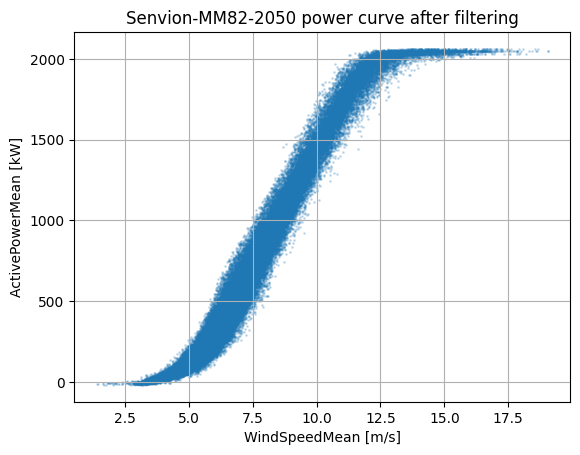

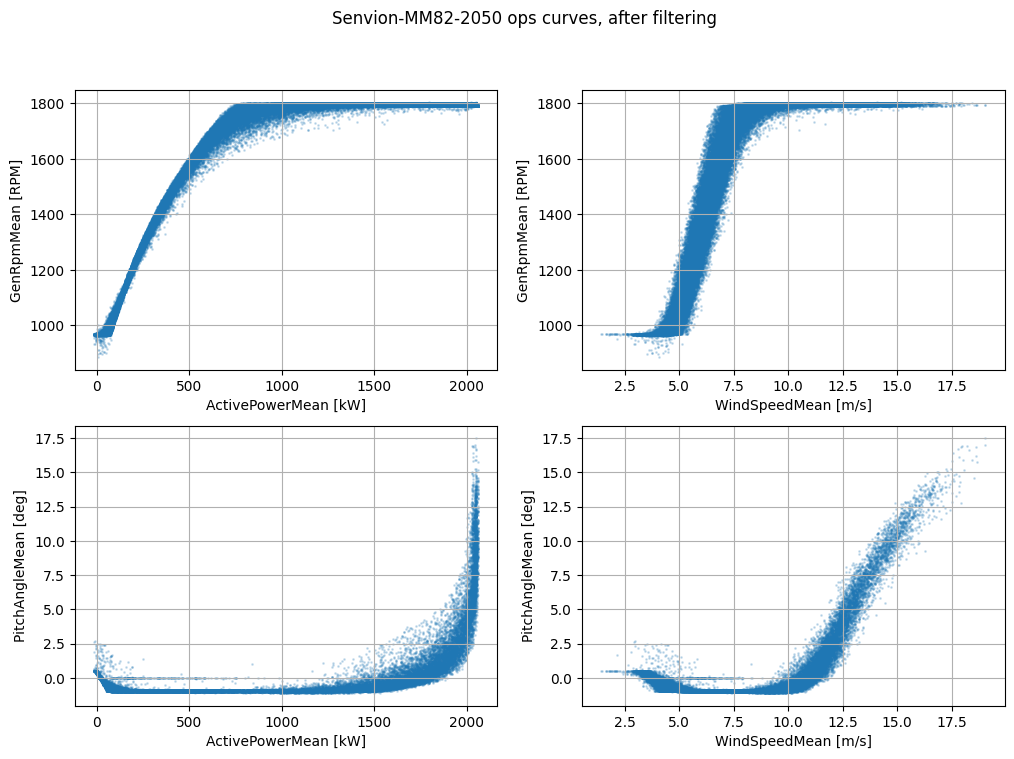

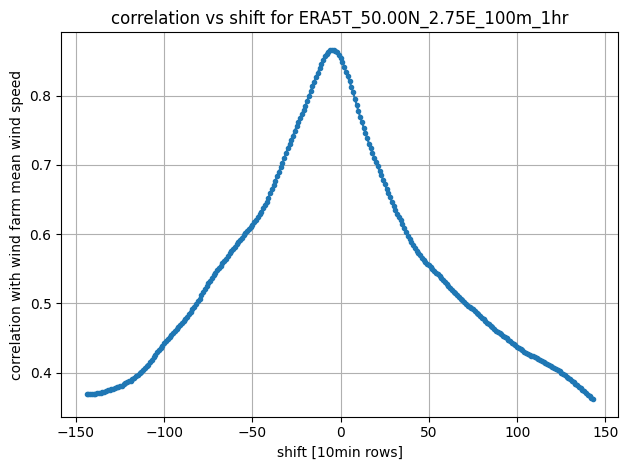

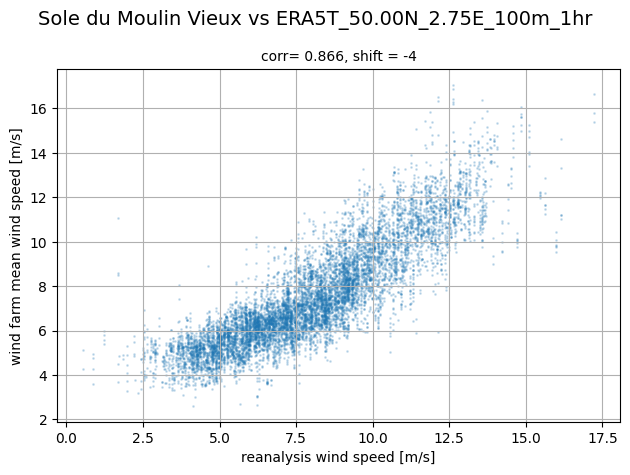

ERA5T_50.00N_2.75E_100m_1hr best correlation is 0.866200 with a shift of -4

ERA5T_50.00N_2.75E_100m_1hr has best correlation: 0.866 with a shift of -4

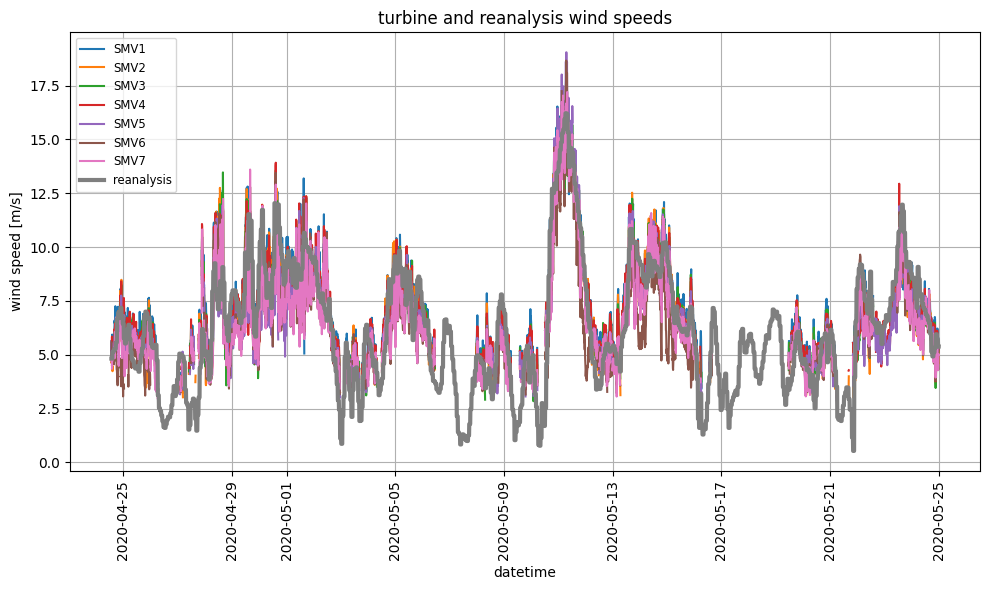

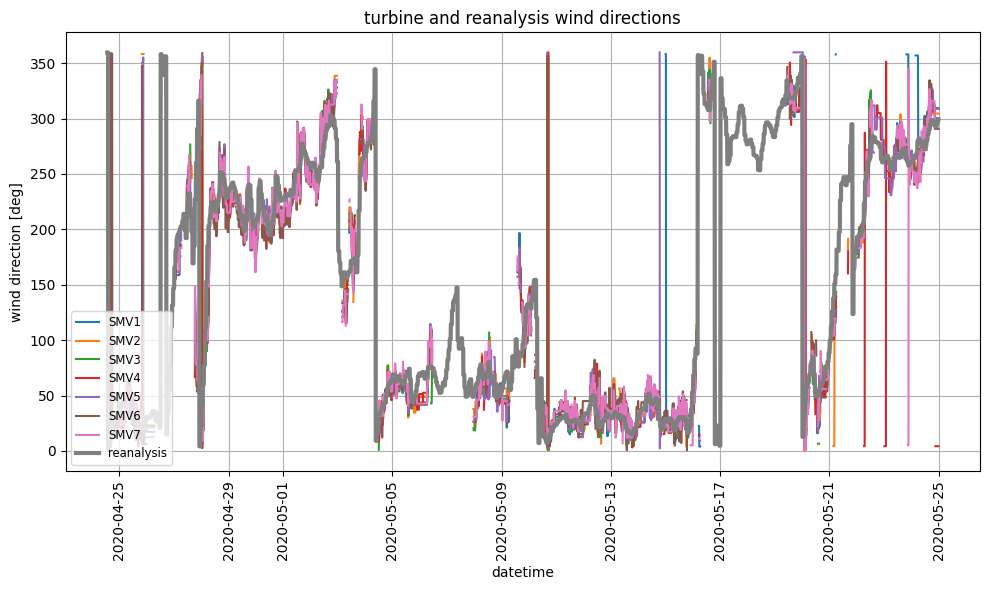

top 3 turbines needing northing correction vs reanalysis_wd before northing:<br>+------+------+<br>| SMV6 | 11.6 |<br>| SMV5 | 11.2 |<br>| SMV3 | 10.3 |<br>+------+------+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd before northing:<br>+------+-----+<br>| SMV7 | 8.1 |<br>+------+-----+

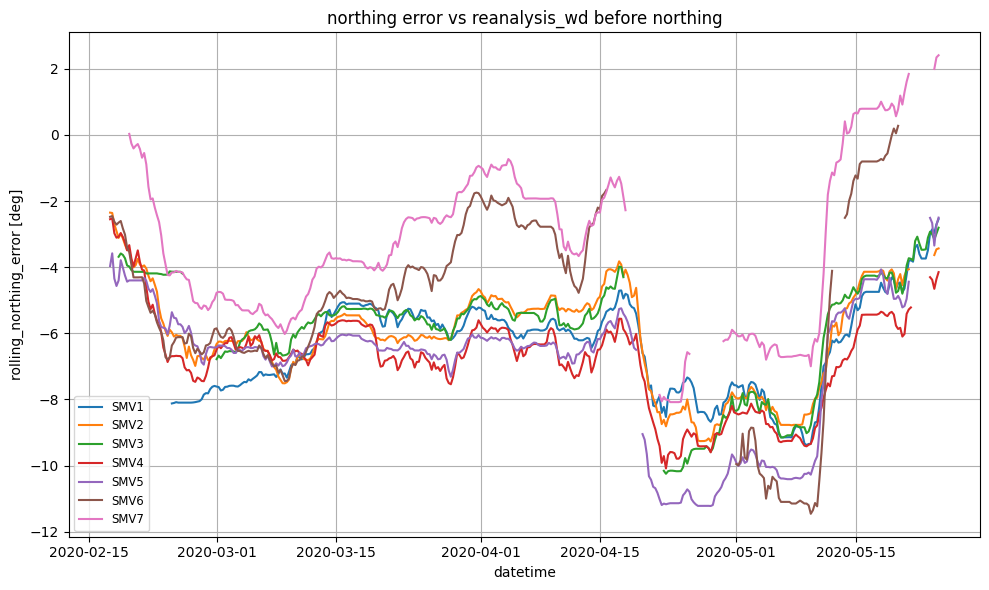

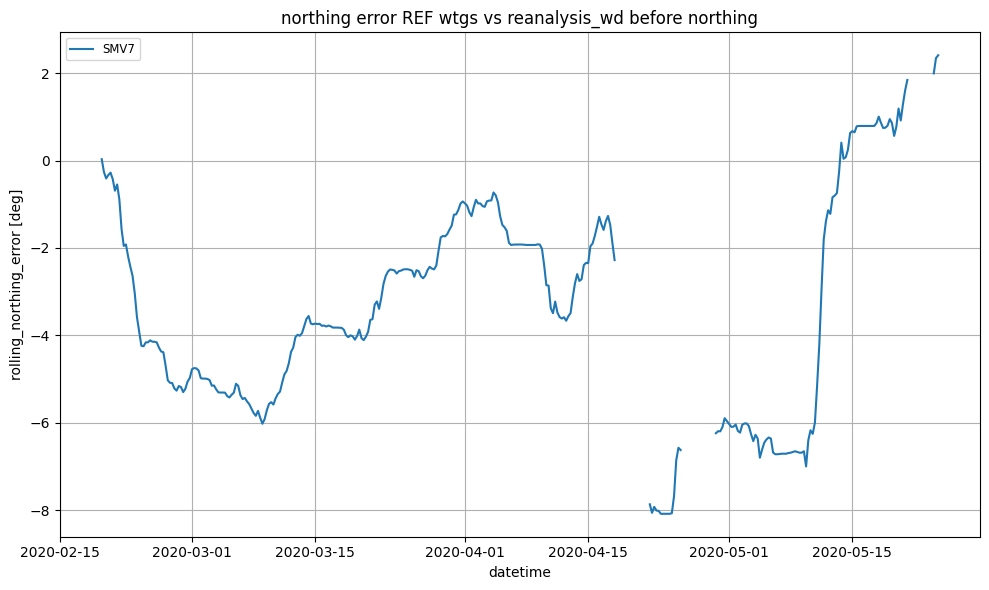

applied 7 northing corrections

top 3 turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV7 | 7.1 |<br>| SMV6 | 6.5 |<br>| SMV3 | 4.7 |<br>+------+-----+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV7 | 7.1 |<br>+------+-----+

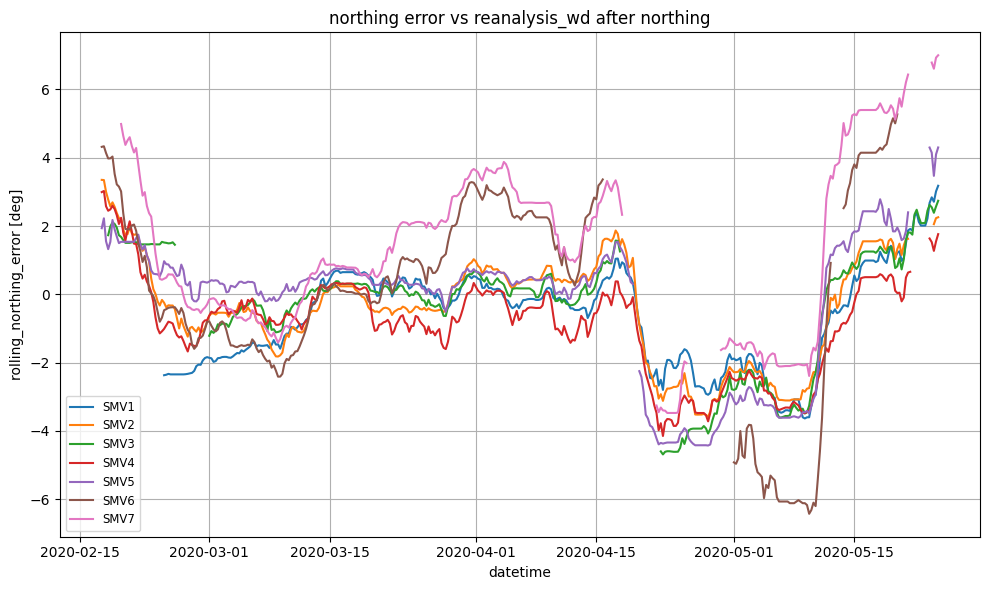

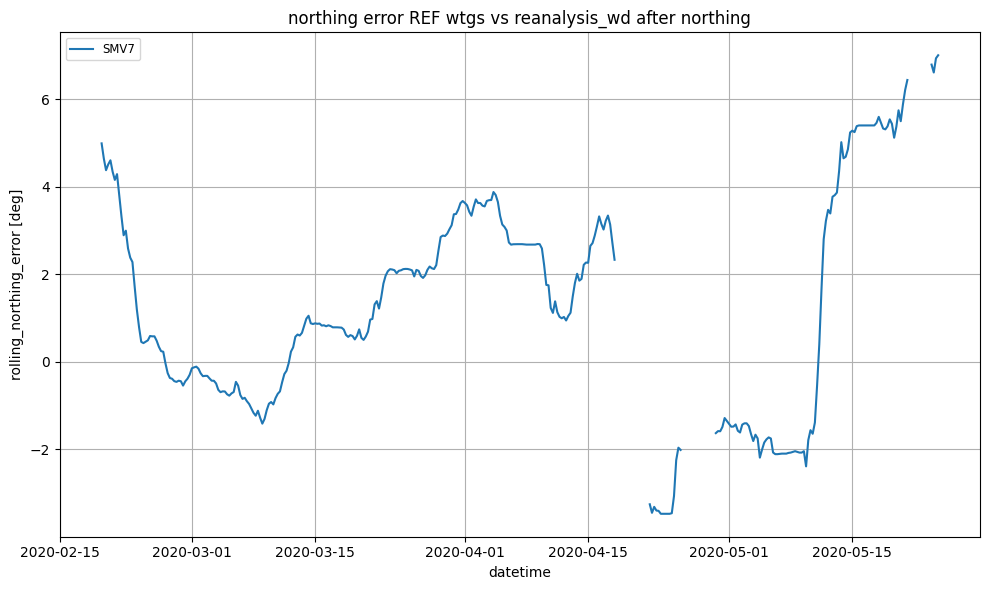

estimated rated wind speed = 14.2 m/s

estimated cut-in wind speed = 3.3 m/s

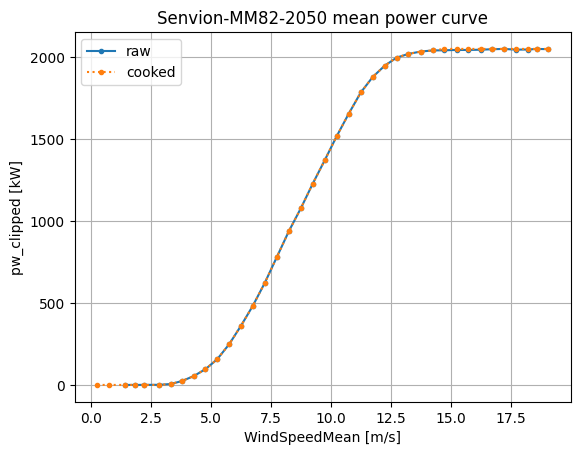

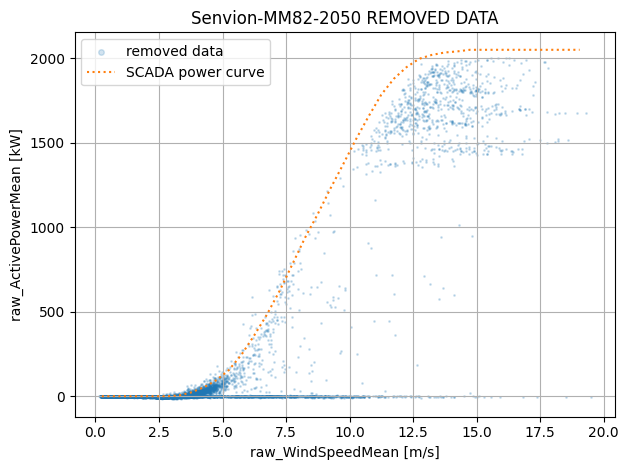

##############################################################################<br># estimate wind speed from power<br>##############################################################################

SMV1 cp correction factor = 0.97

SMV2 cp correction factor = 0.99

SMV3 cp correction factor = 1.00

SMV4 cp correction factor = 0.98

SMV5 cp correction factor = 1.02

SMV6 cp correction factor = 1.03

SMV7 cp correction factor = 1.02

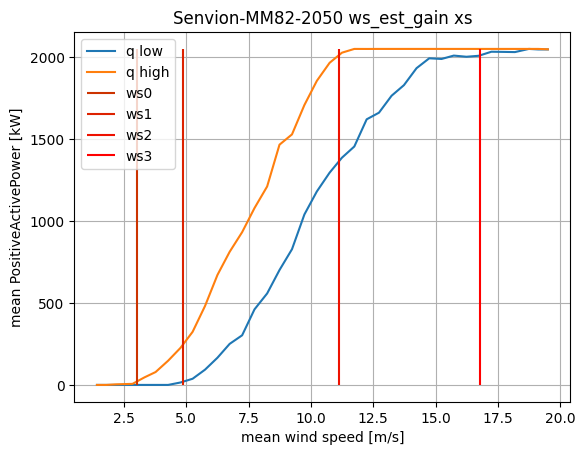

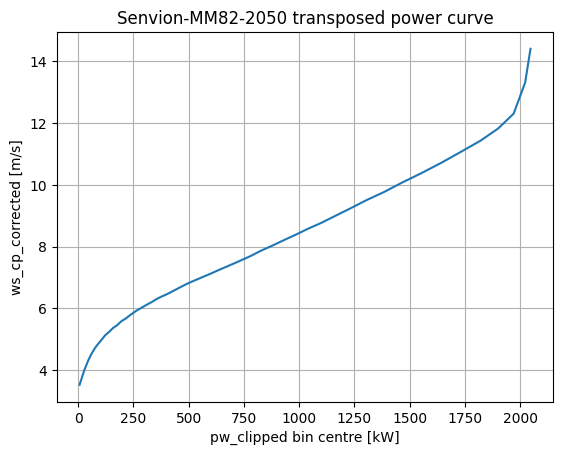

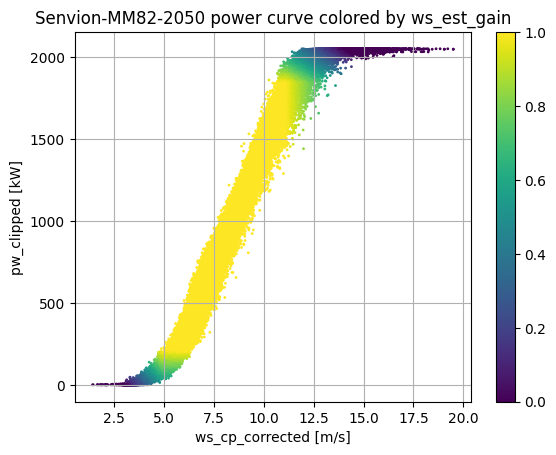

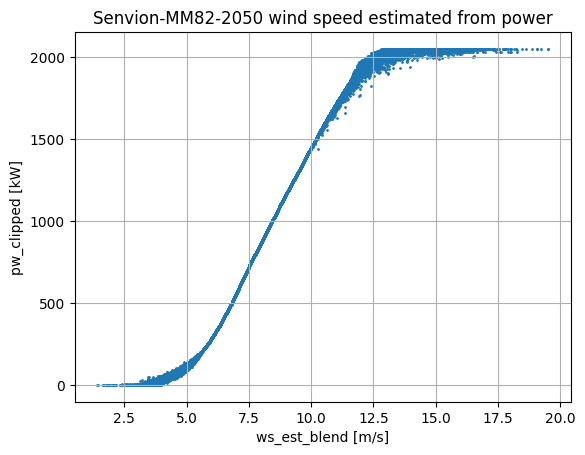

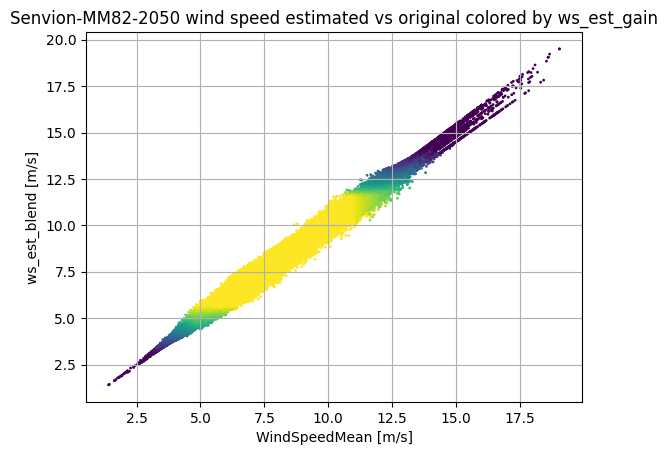

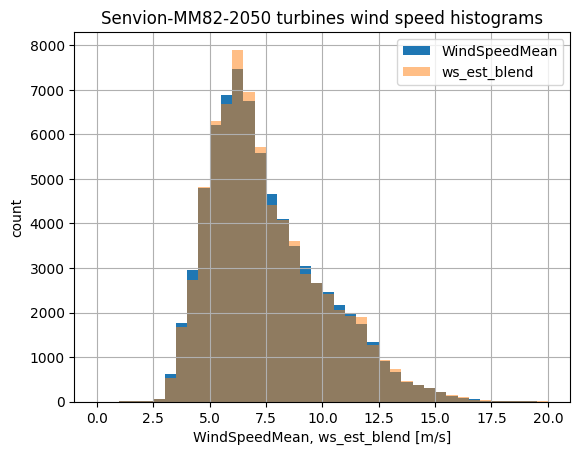

Senvion-MM82-2050 76.1% of rows are waking

Senvion-MM82-2050 14.8% of rows are not waking

Senvion-MM82-2050 9.1% of rows have unknown or partial waking

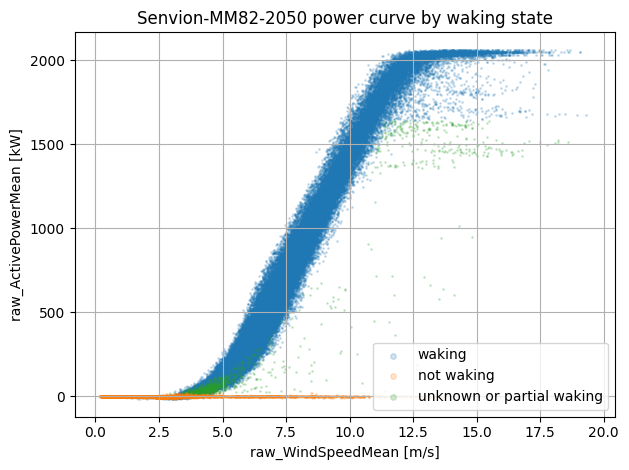

In [11]:
assessment_inputs = AssessmentInputs.from_cfg(
    cfg=cfg,
    plot_cfg=plot_cfg,
    toggle_df=toggle_df,
    scada_df=scada_df,
    metadata_df=metadata_df,
    reanalysis_datasets=[reanalysis_dataset],
    cache_dir=None,
)

## run the wind-up analysis
The wind-up analysis runs for each test-ref combo, in this case there are two (SMV6-SMV7 and SMV6-SMV7)

test turbines: ['SMV6', 'SMV5']

ref list: ['SMV7']

turbines to test: ['SMV6', 'SMV5']

filter_all_test_wtgs_together SMV5 set 400 rows [2.9%] to NA

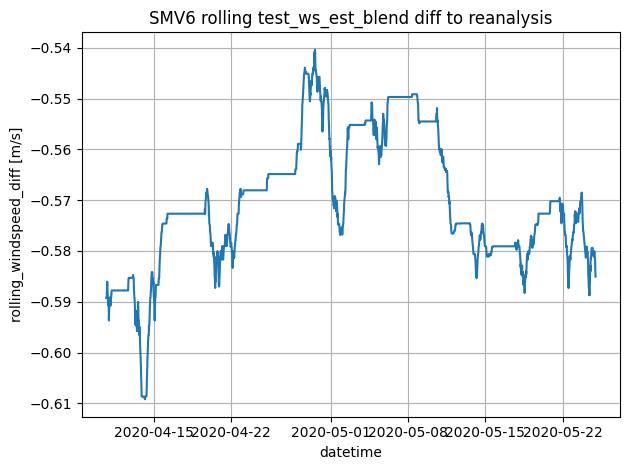

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

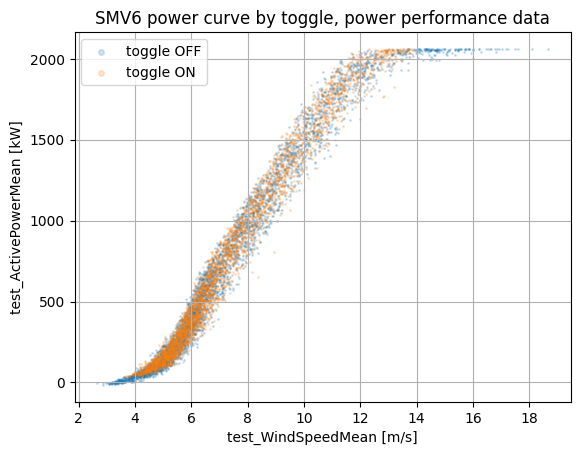

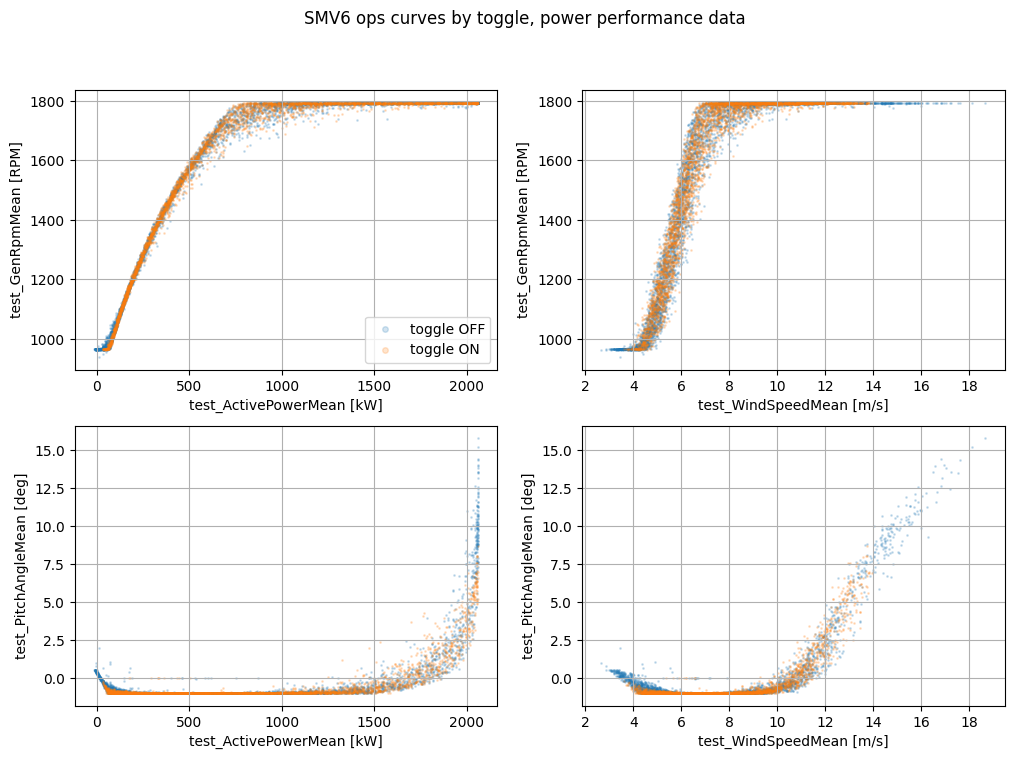

analysing SMV6 SMV7, loop_counter=0

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

removed 11390 [81.3%] rows from ref_df using ref_wd_filter

SMV7 wake free directions with data min=197.0 max=246.0

removed 0 [0.0%] rows from ref_df using require_ref_wake_free

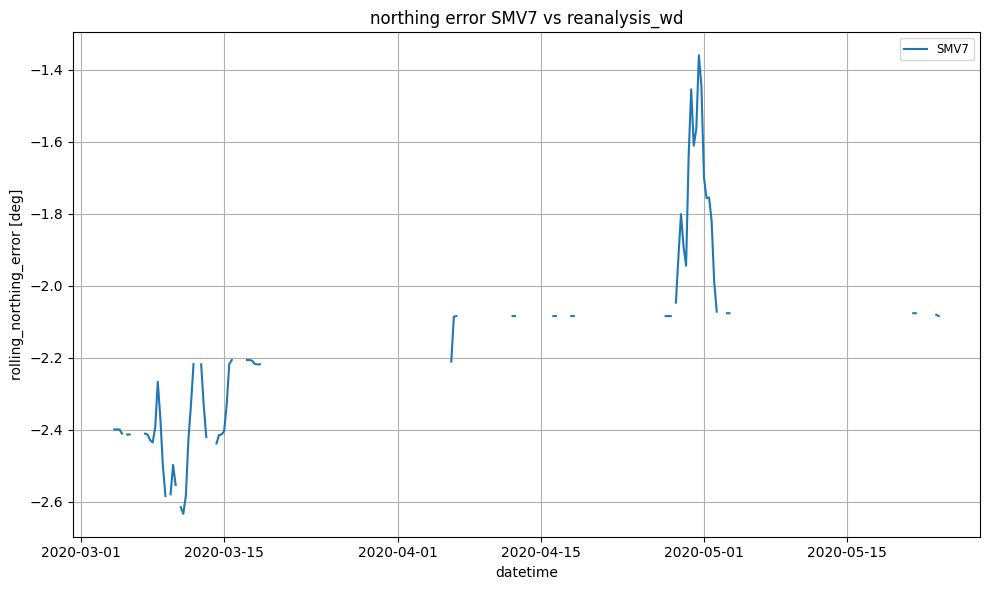

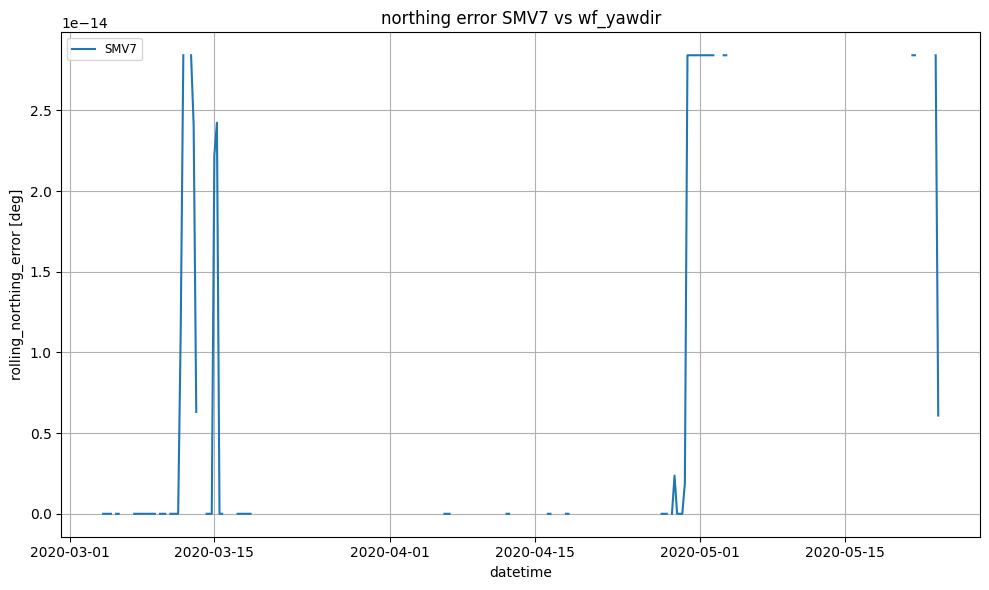

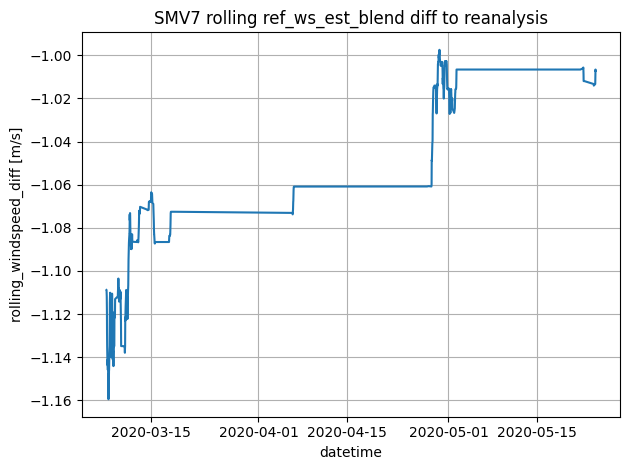

removed 6968 [49.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time

top 3 SMV6 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 98.2 |<br>| SMV7 offline |  1.6 |<br>| unknown      |  0.2 |<br>+--------------+------+

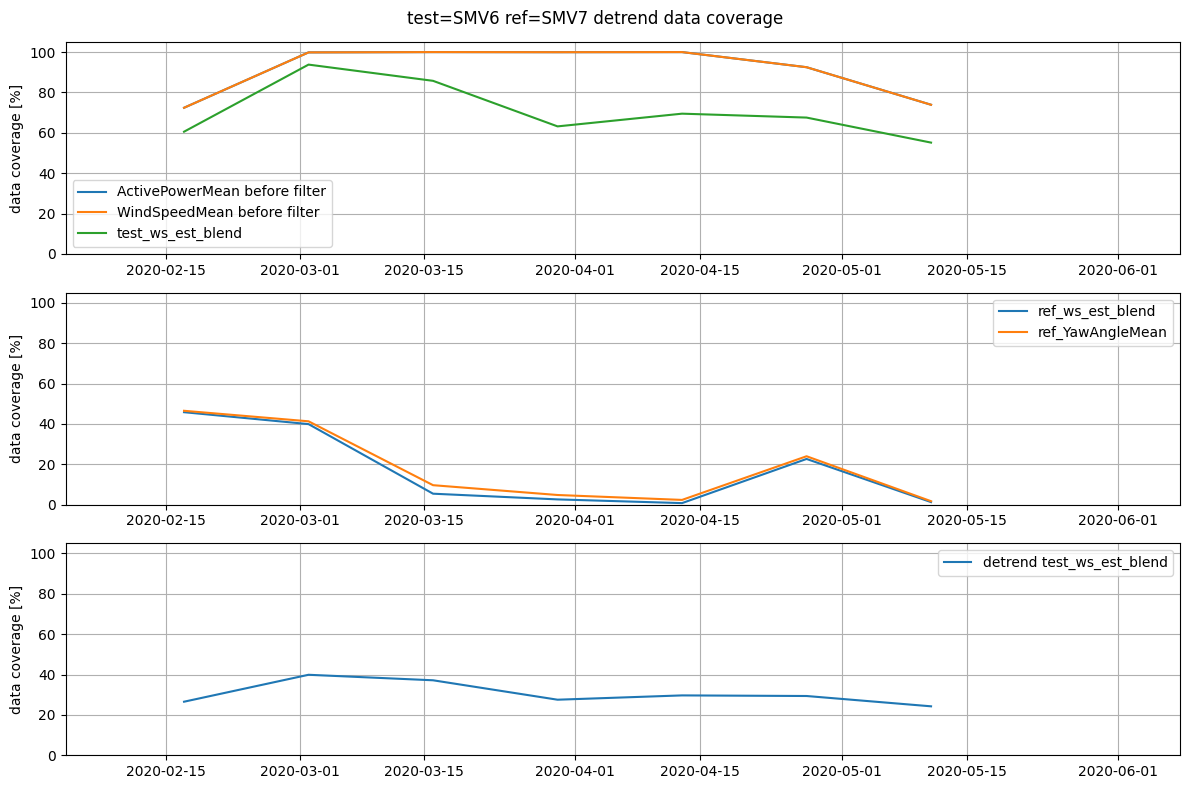

removed 0 bad detrend results

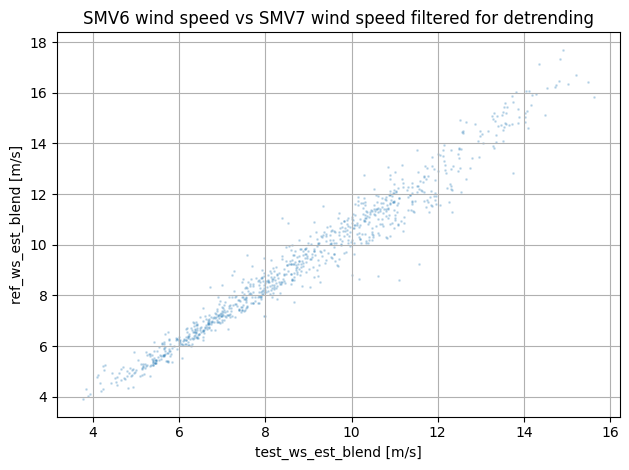

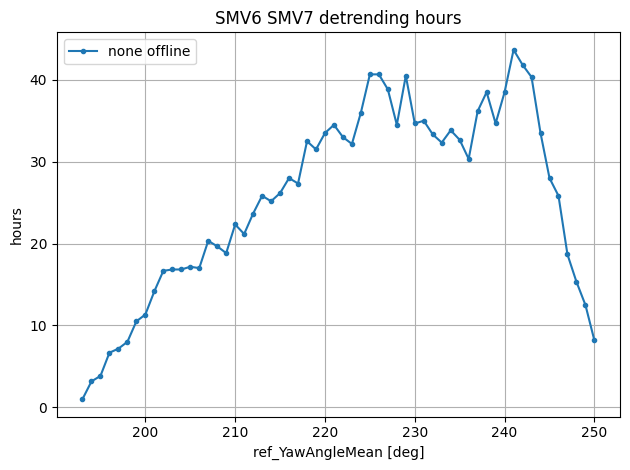

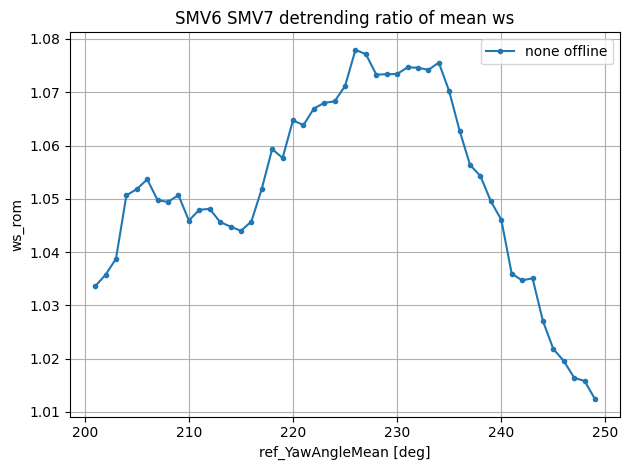

SMV7 Ops Curve Shift warning: abs(CurveTypes.PITCH) > 0.1: 0.223

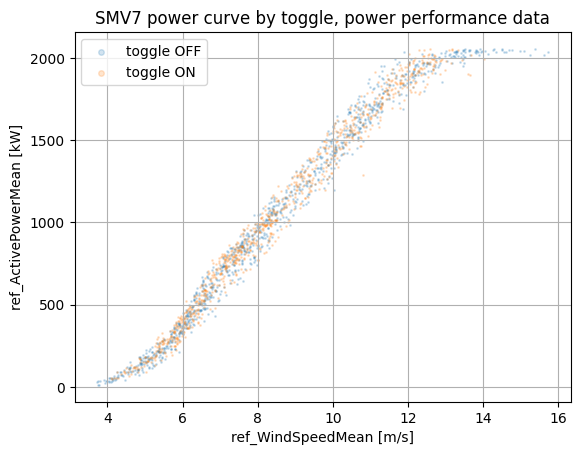

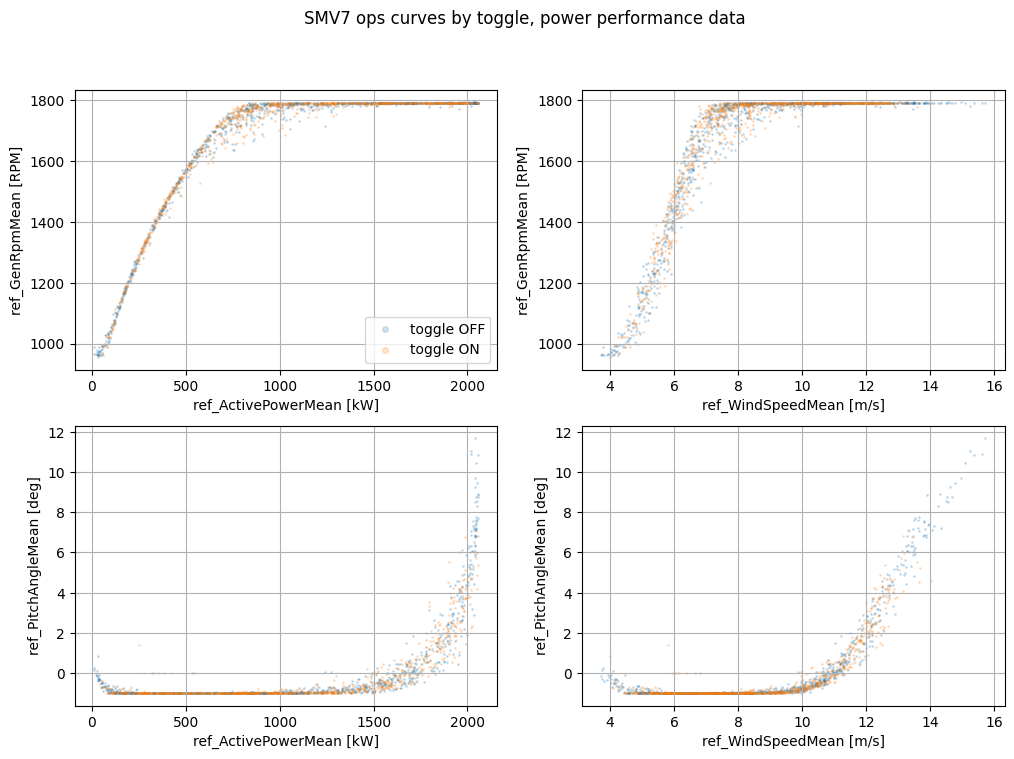

top 3 SMV6 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 98.2 |<br>| SMV7 offline |  1.6 |<br>| unknown      |  0.2 |<br>+--------------+------+

top 1 SMV6 SMV7 waking scenarios [%]:

+--------------+-------+<br>| none offline | 100.0 |<br>+--------------+-------+

detrend applied to 49 scenario - directions

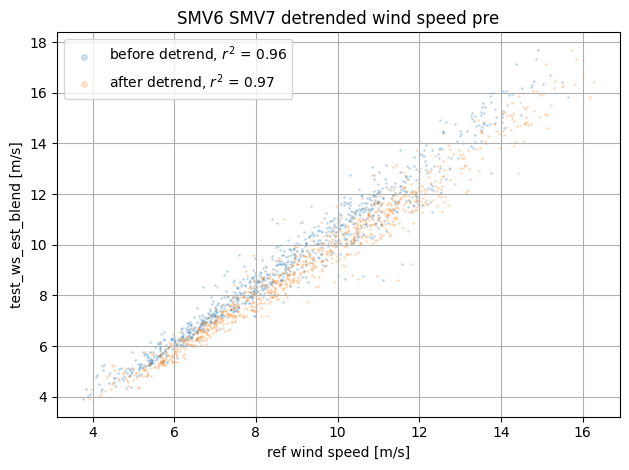

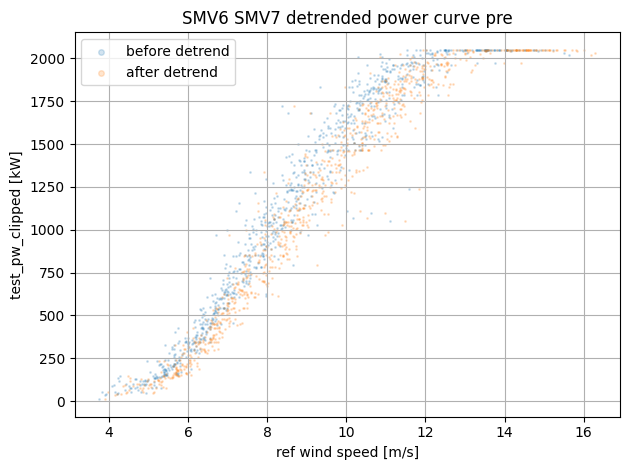

detrend applied to 49 scenario - directions

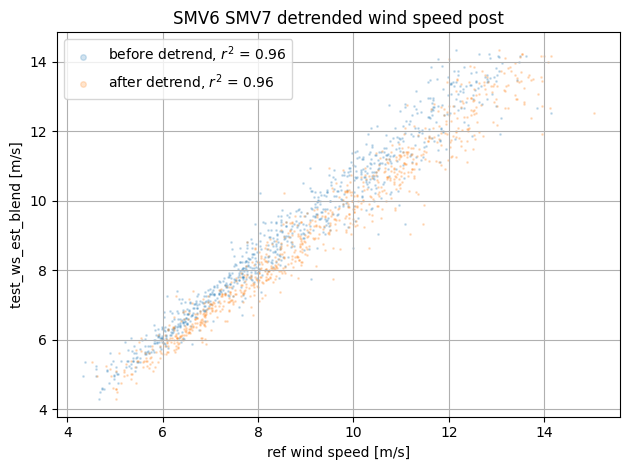

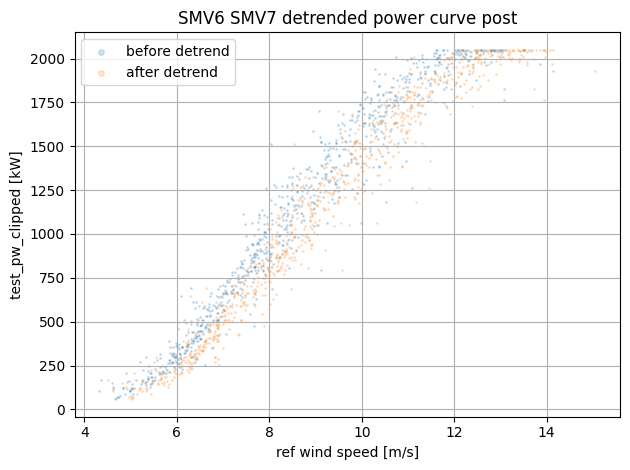

detrend improved pre_df ws r2 by 0.00 (0.96 to 0.97)

detrend improved post_df ws r2 by 0.00 (0.96 to 0.96)

removed 0 bad detrend results

removed 0 bad detrend results

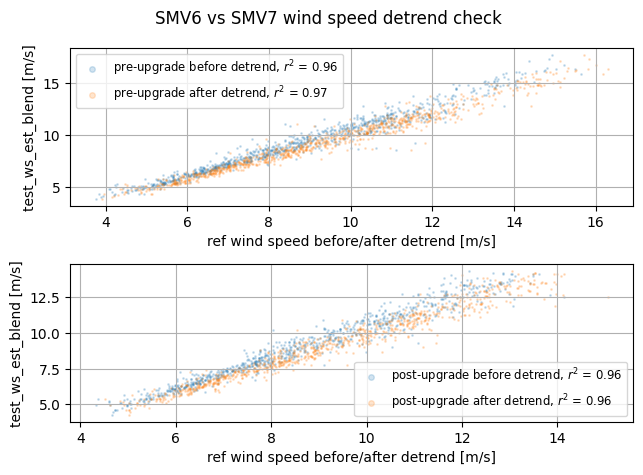

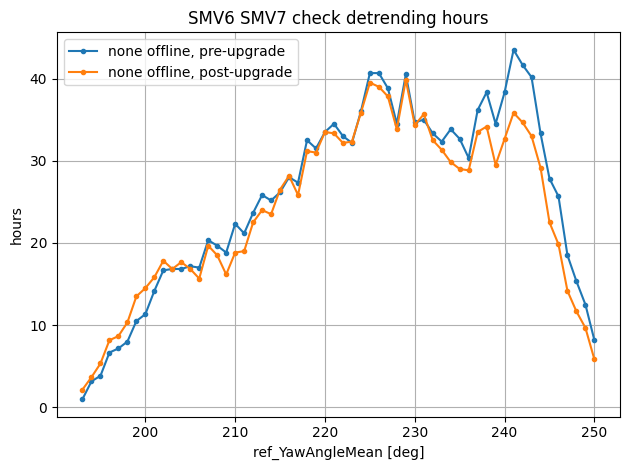

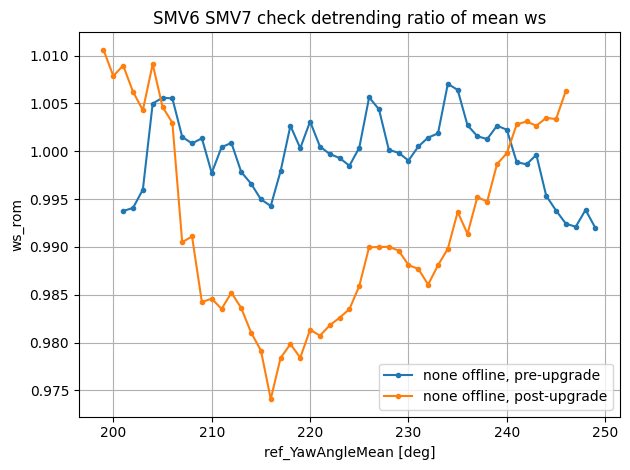

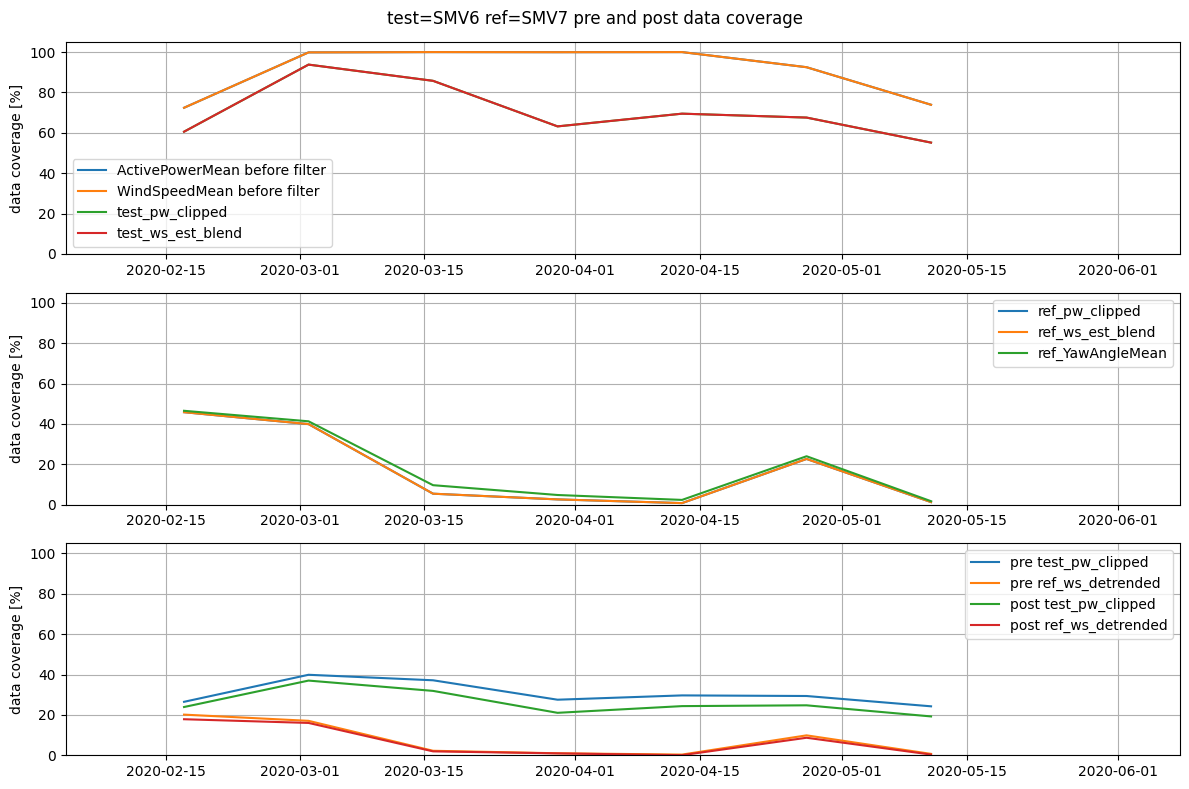

removed 71 [7.8%] rows from pre_df using any_within_timedelta pairing filter

removed 12 [1.4%] rows from post_df using any_within_timedelta pairing filter

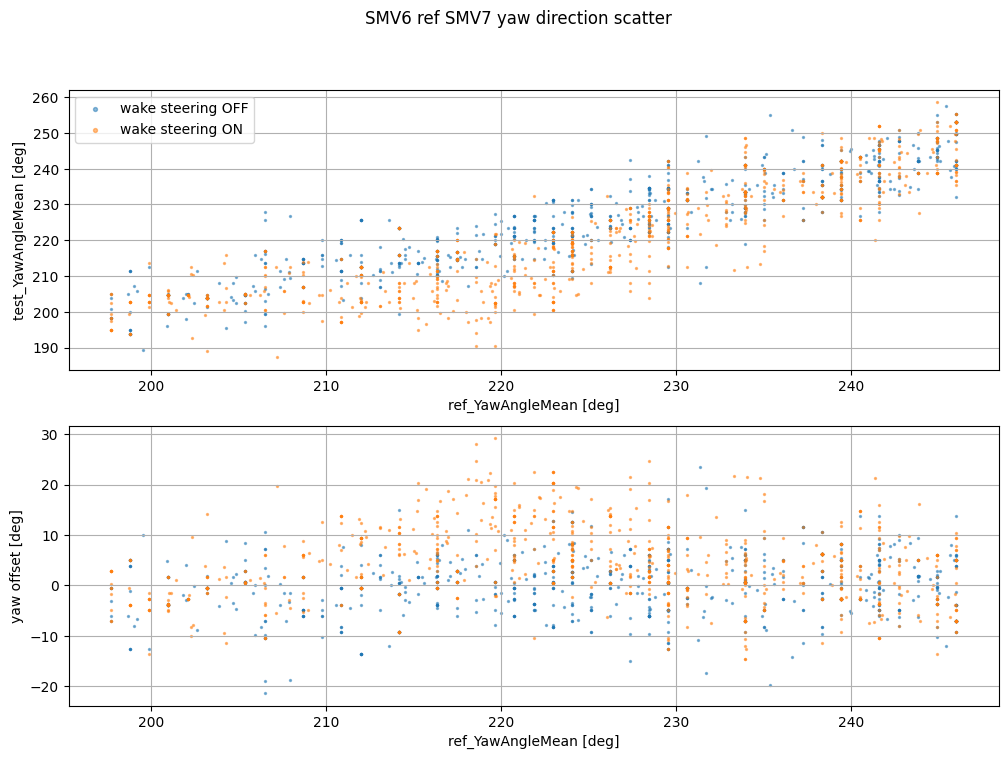

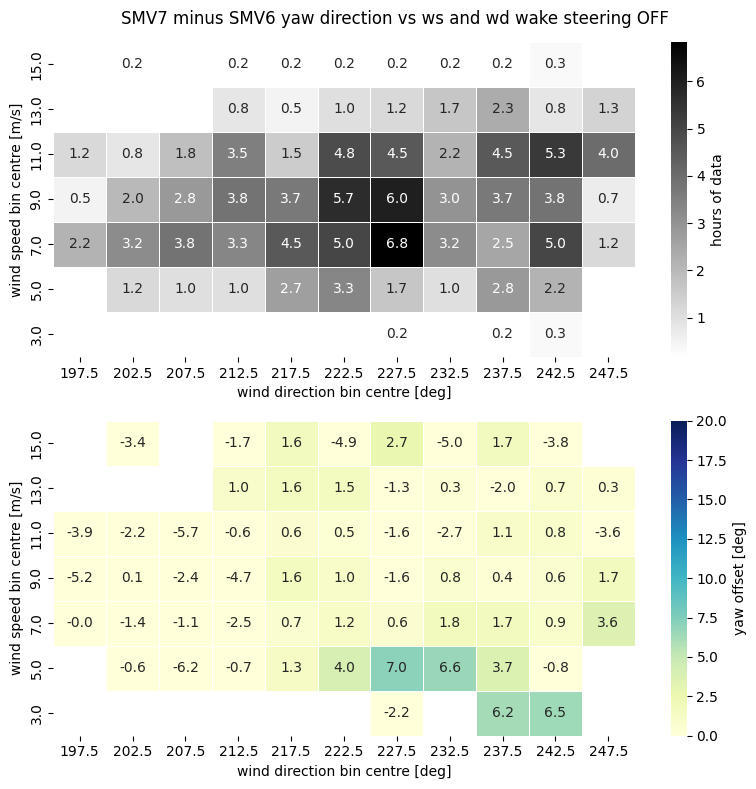

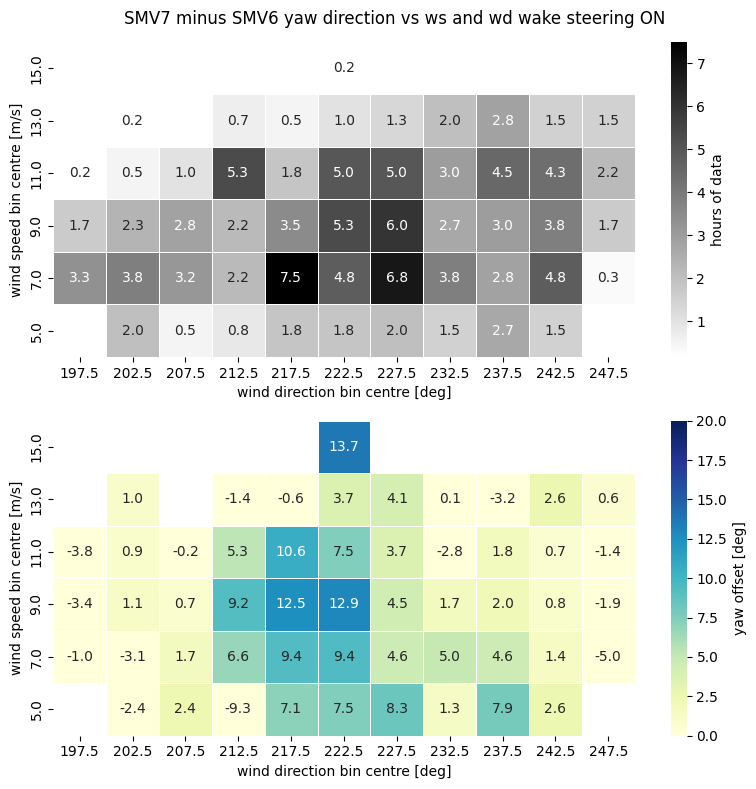

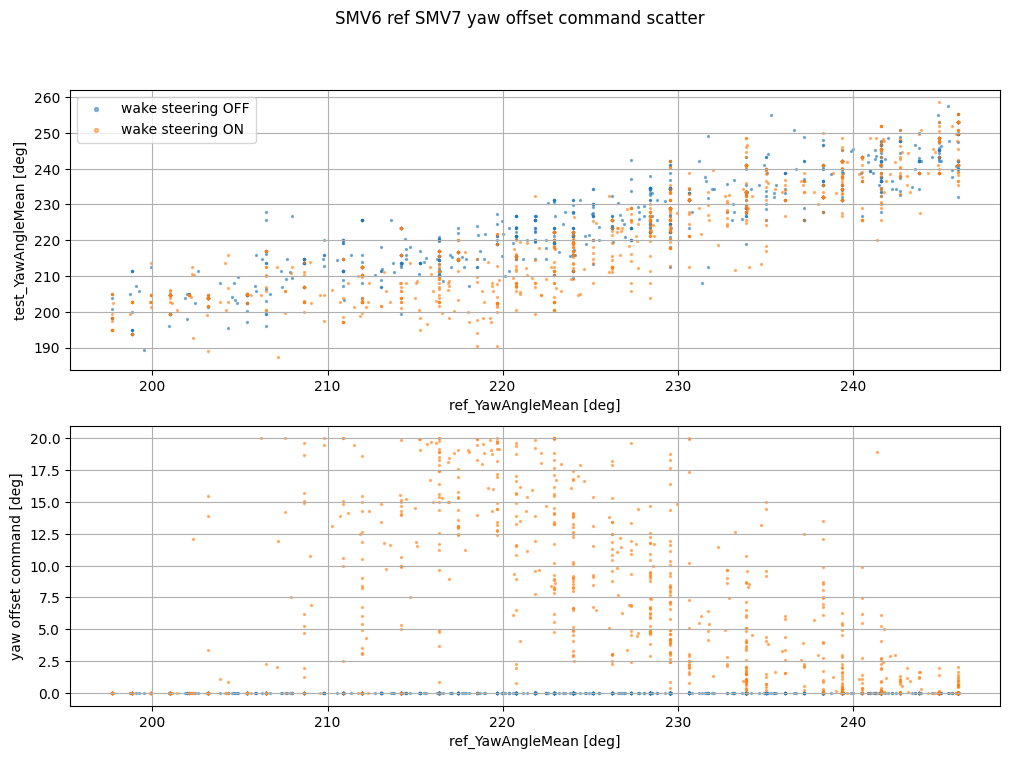

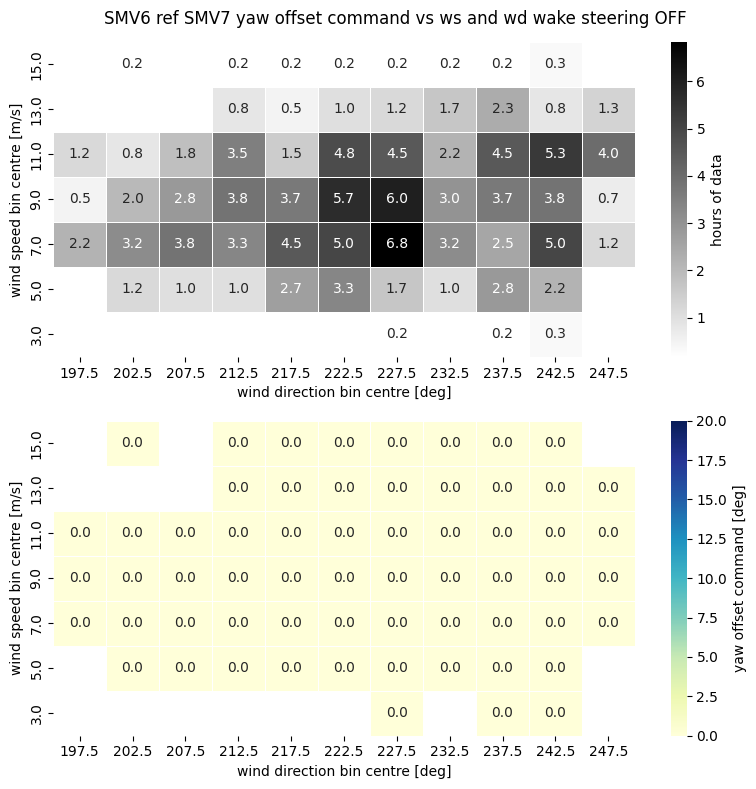

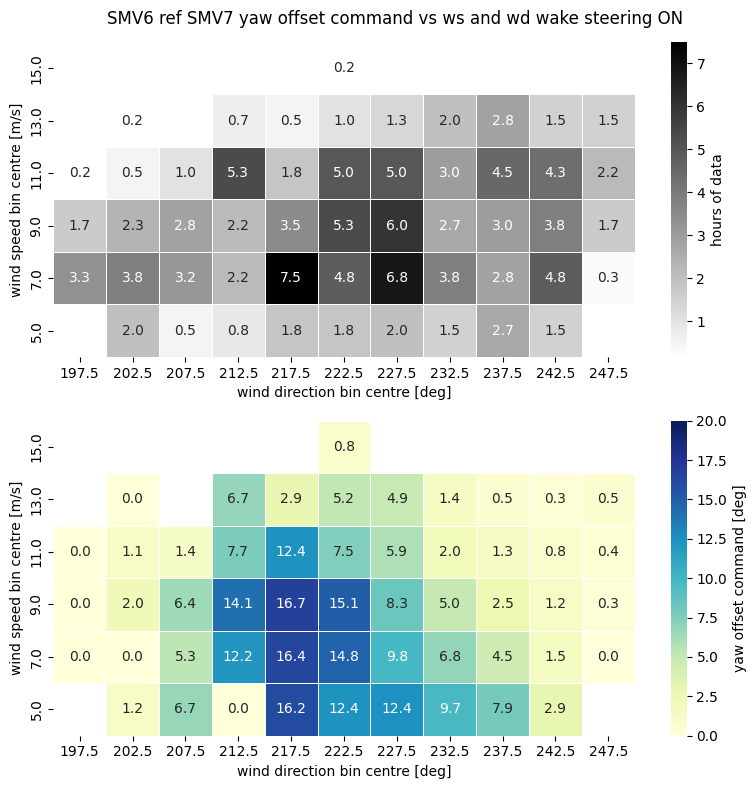

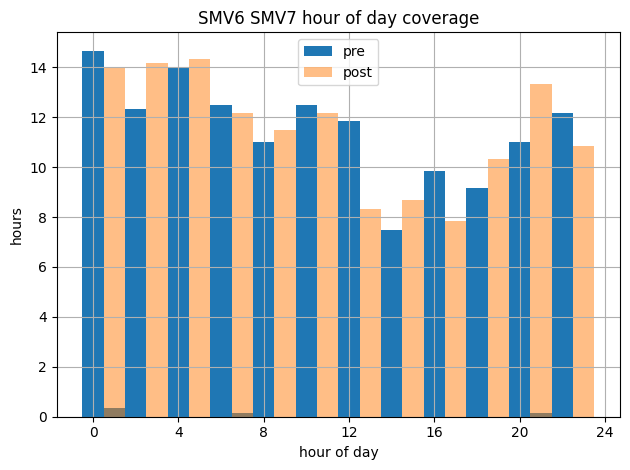

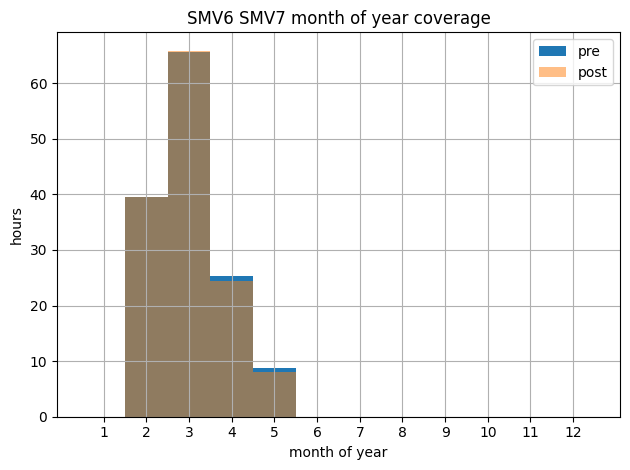

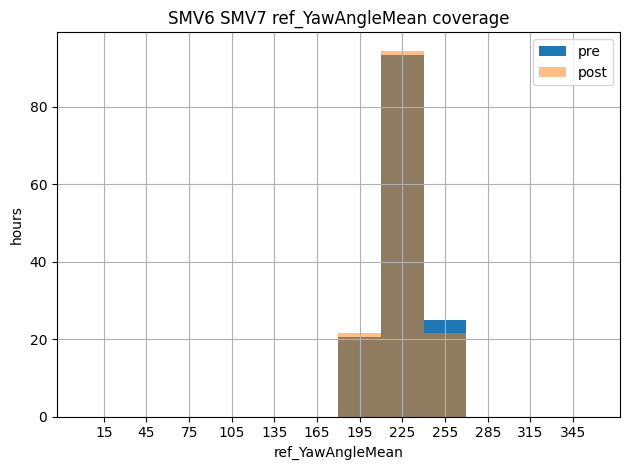

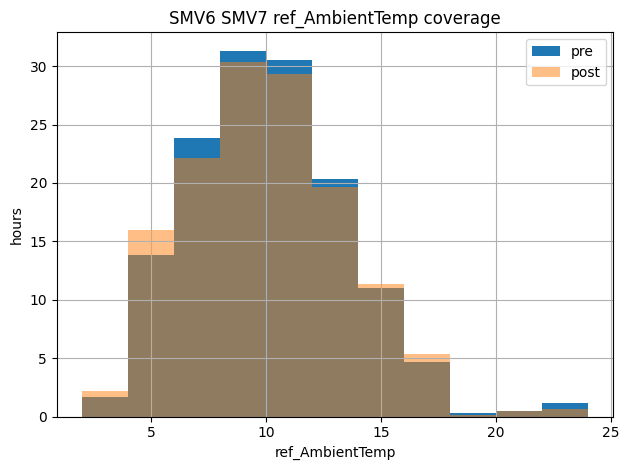

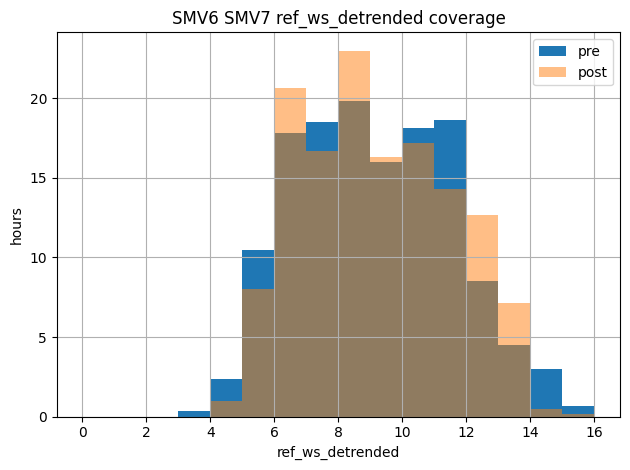

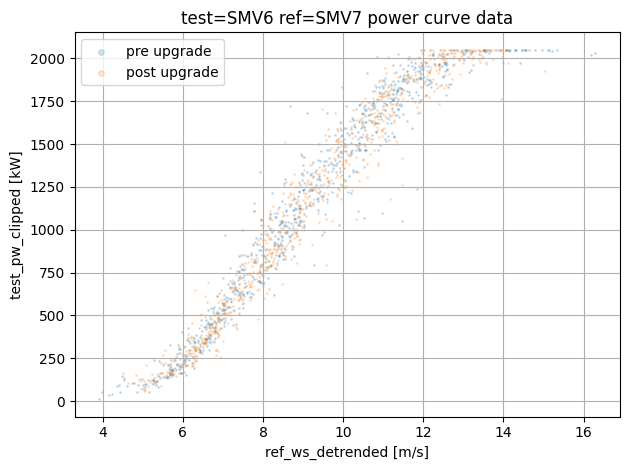

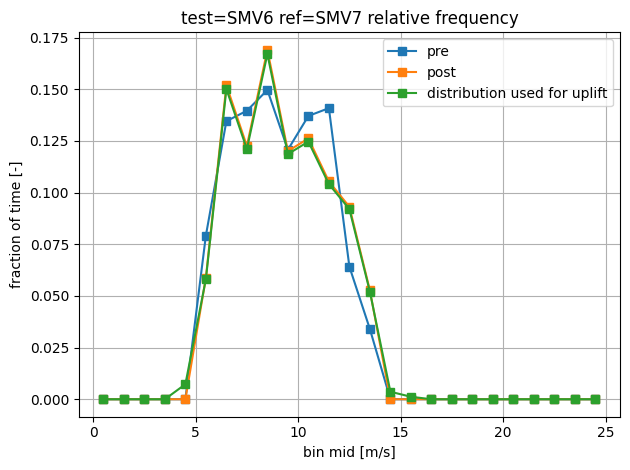

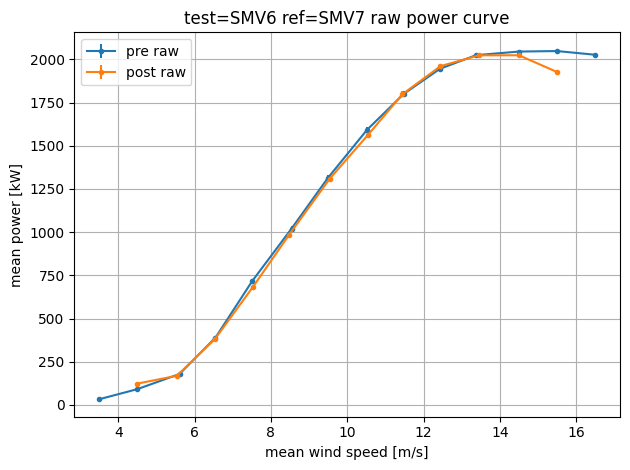

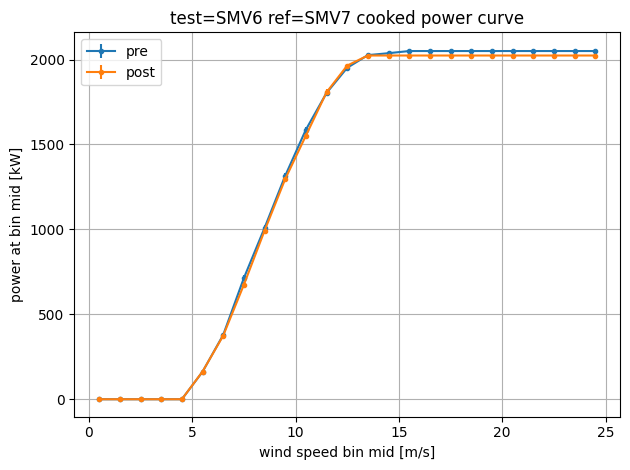

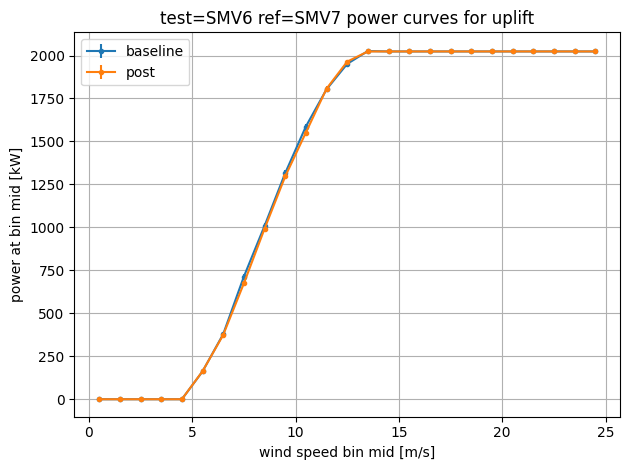

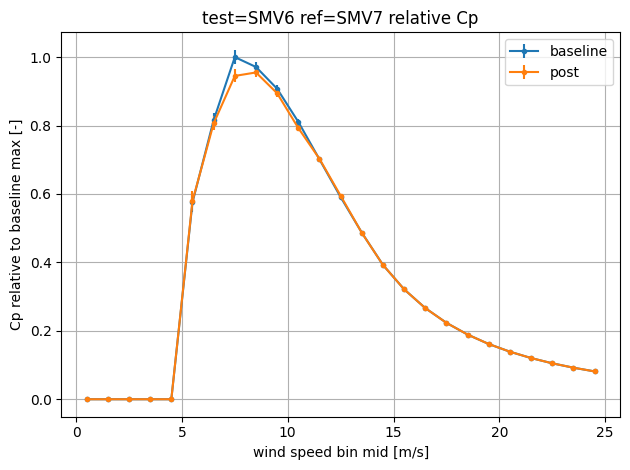

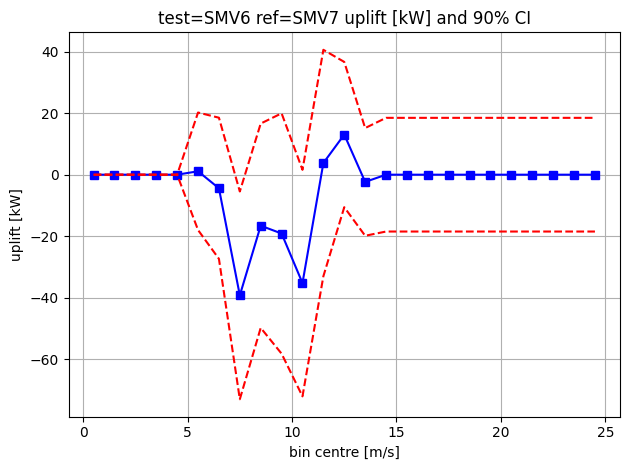

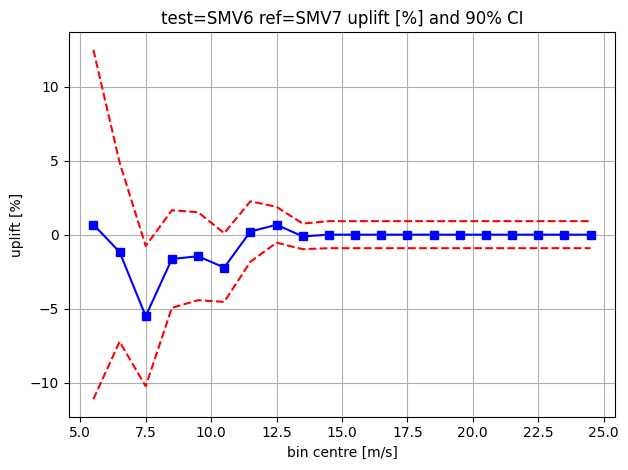

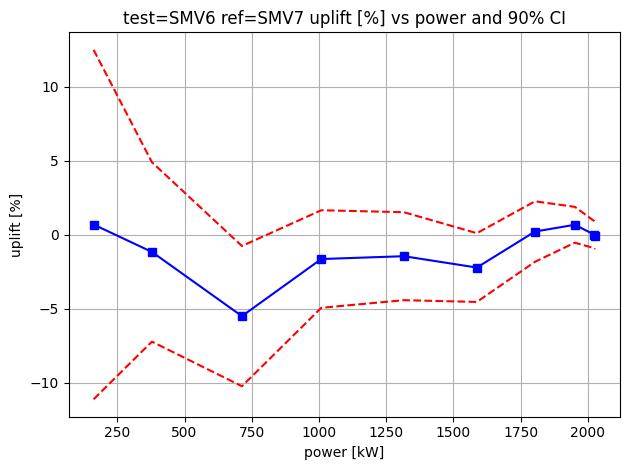

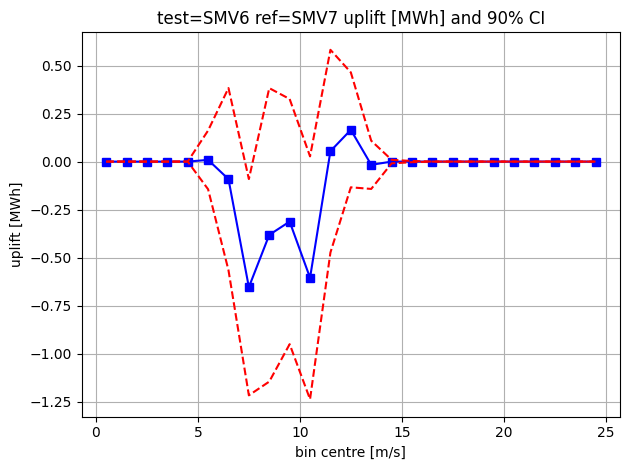

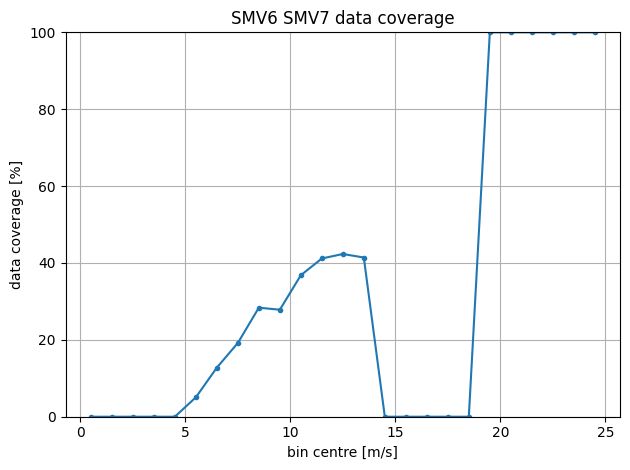

<br>results for test=SMV6 ref=SMV7:<br>

hours pre = 132.5

hours post = 136.0

<br>uplift estimate before adjustments = -1.2 %

<br>power only uplift estimate = -1.2 %

reversed (power only) uplift estimate = -1.0 %<br>

Running block bootstrapping uncertainty analysis n_samples = 400

  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):<br>  median = -1.1 %<br>  lower = -2.0 %<br>  upper = -0.4 %<br>  unc_one_sigma = 0.5 %

<br>cat A 1 sigma unc = 0.6 %

abs reversal error / 2 = 0.1 %

bootstrap 1 sigma unc = 0.5 %

missing bins scale factor = 1.000

final 1 sigma unc = 0.6 %<br>

final uplift estimate = -1.0 %

final P95 uplift estimate = -2.0 %

final P5 uplift estimate = -0.1 %

{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 314.4465998943834, 'bearing_deg': 173.69483366777283, 'ref_max_northing_error_v_reanalysis': np.float64(2.6590754551807976), 'ref_max_northing_error_v_wf': np.float64(2.842170943040401e-14), 'ref_max_ws_drift': np.float64(0.08697706942338845), 'ref_max_ws_drift_pp_period': np.float64(0.08697706942338845), 'ref_powercurve_shift': np.float64(0.003117456887993697), 'ref_rpm_shift': np.float64(0.0015313319638985412), 'ref_pitch_shift': np.float64(0.22323442242659364), 'ref_wind_speed_shift': np.float64(-0.0009576682888782218), 'detrend_pre_r2_improvement': np.float64(0.004942384513915488), 'detrend_post_r2_improvement': np.float64(0.0011487228730558963), 'mean_power_pre': np.float64(1149.2323289820358), 'mean_power_post': np.float64(1148.4157066585956), 'mean_test_yaw_offset_pre': np.float64(-0.022511156888877885), 'mean_test_yaw_offset_post': np.float64(3.8213264238880478), 'mean_test_yaw_offset_command_pre': np.float64(0.0002638323353293413), 'mean_test_yaw_offset_command_post': np.float64(6.636967675544794), 'mean_ref_yaw_offset_command_pre': np.float64(0.0), 'test_ref_warning_counts': 1, 'time_calculated': Timestamp('2024-10-09 11:22:51.699109+0000', tz='UTC'), 'uplift_frc': np.float64(-0.010361770845398625), 'unc_one_sigma_frc': np.float64(0.0057851151530948705), 't_value_one_sigma': np.float64(1.000630119597717), 'missing_bins_unc_scale_factor': 1, 'pp_valid_hours_pre': np.float64(132.5), 'pp_valid_hours_post': np.float64(136.0), 'pp_valid_hours': np.float64(268.5), 'pp_data_coverage': np.float64(0.11496467565831728), 'pp_invalid_bin_count': np.int64(16), 'uplift_noadj_frc': np.float64(-0.011505660672016103), 'unc_one_sigma_noadj_frc': np.float64(0.0057851151530948705), 'poweronly_uplift_frc': np.float64(-0.012003308408347353), 'reversed_uplift_frc': np.float64(-0.009715528755112396), 'reversal_error': np.float64(0.0022877796532349576), 'unc_one_sigma_lowerbound_frc': np.float64(0.0011438898266174788), 'unc_one_sigma_bootstrap_frc': np.float64(0.0049406532714673), 'uplift_p5_frc': np.float64(-0.000846103203498606), 'uplift_p95_frc': np.float64(-0.019877438487298643), 'wind_up_version': '0.1.9', 'test_wtg': 'SMV6', 'test_pw_col': 'test_pw_clipped', 'lt_wtg_hours_raw': 0, 'lt_wtg_hours_filt': 0, 'test_max_ws_drift': np.float64(0.03653354205095605), 'test_max_ws_drift_pp_period': np.float64(0.03653354205095605), 'test_powercurve_shift': np.float64(0.0010615707256107498), 'test_rpm_shift': np.float64(0.0011316163321652972), 'test_pitch_shift': np.float64(0.07625563544756919), 'test_wind_speed_shift': np.float64(-0.00621481122601375), 'preprocess_warning_counts': 0, 'test_warning_counts': 0}

warning summary: preprocess_warning_counts=0, test_warning_counts=0, test_ref_warning_counts=1

finished analysing SMV6 SMV7<br>

filter_all_test_wtgs_together SMV6 set 739 rows [5.3%] to NA

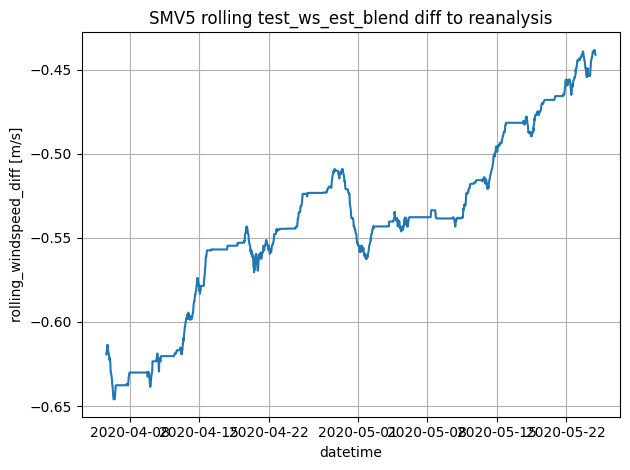

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

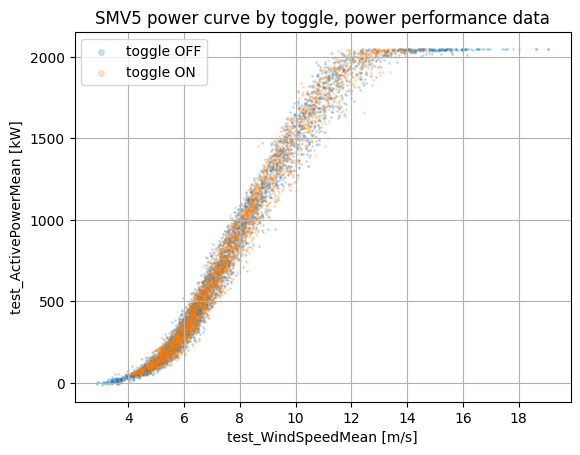

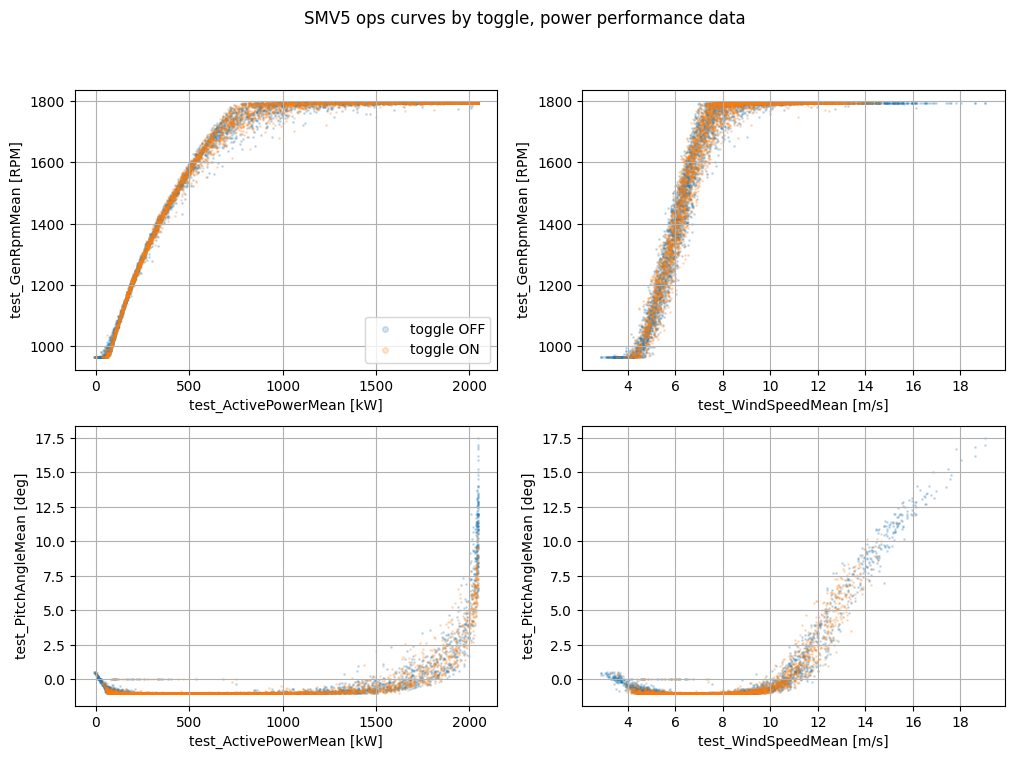

analysing SMV5 SMV7, loop_counter=1

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

removed 11390 [81.3%] rows from ref_df using ref_wd_filter

SMV7 wake free directions with data min=197.0 max=246.0

removed 0 [0.0%] rows from ref_df using require_ref_wake_free

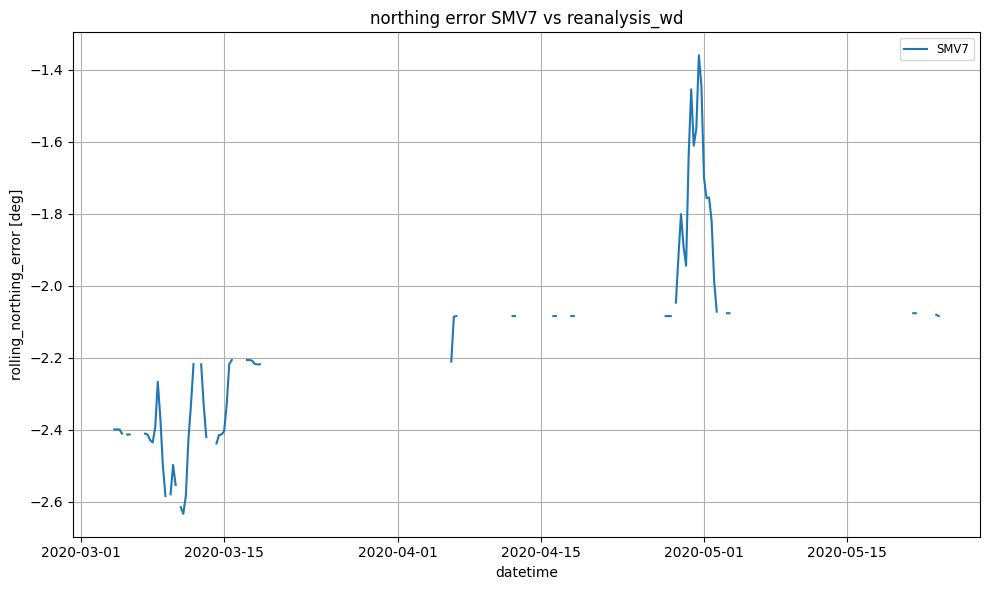

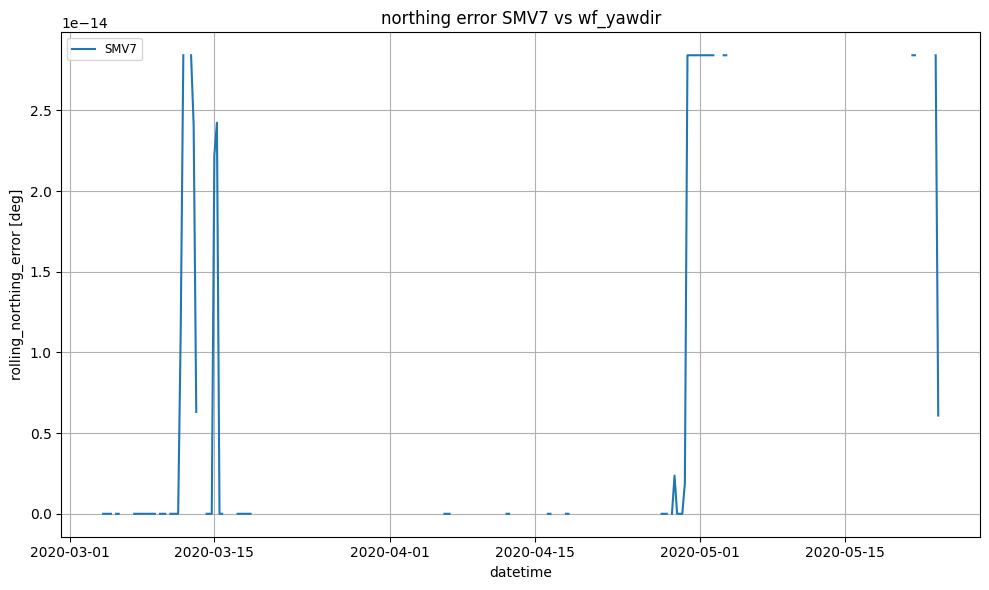

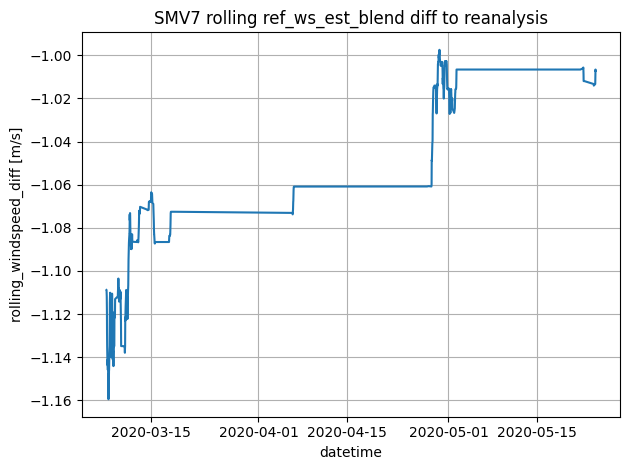

removed 6968 [49.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time

top 5 SMV5 SMV7 waking scenarios [%]:

+-------------------+------+<br>| none offline      | 86.5 |<br>| SMV6 SMV7 offline |  5.3 |<br>| SMV6 offline      |  4.1 |<br>| unknown           |  4.1 |<br>| SMV7 offline      |  0.1 |<br>+-------------------+------+

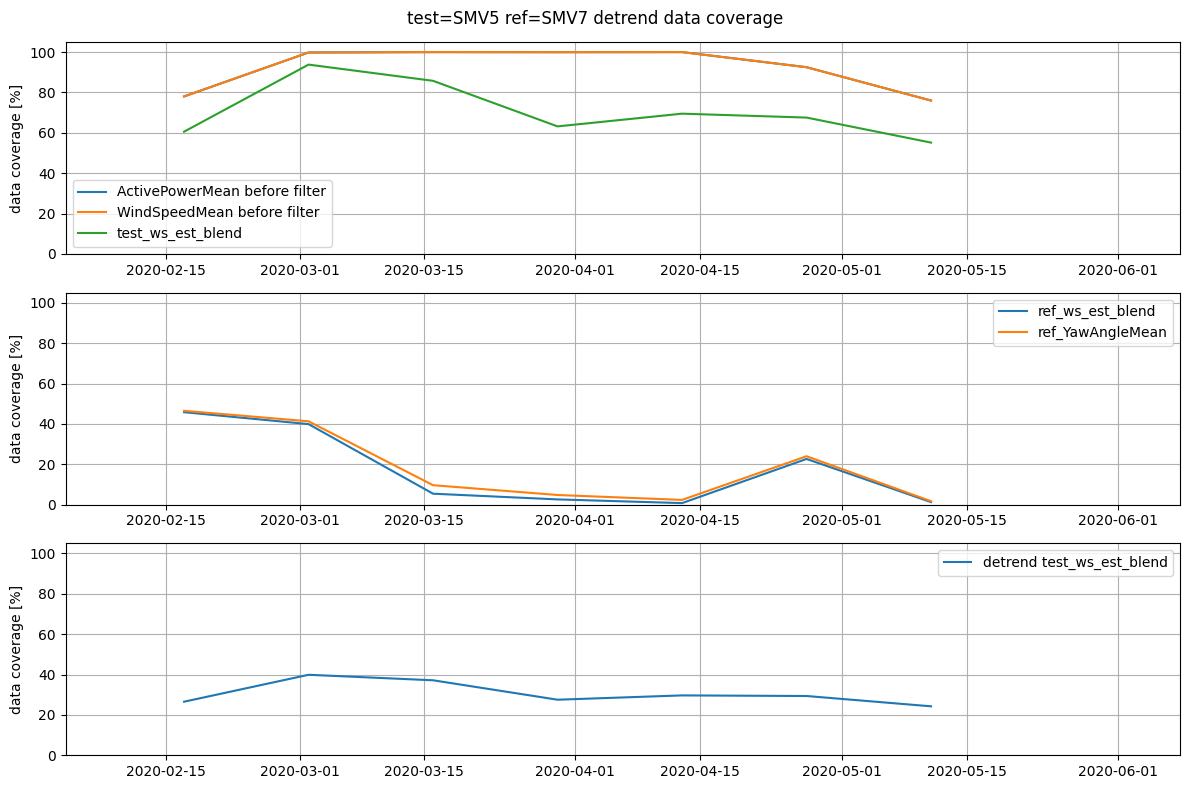

removed 0 bad detrend results

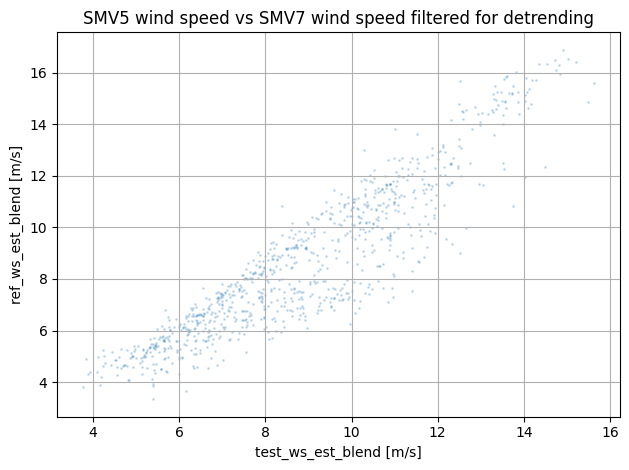

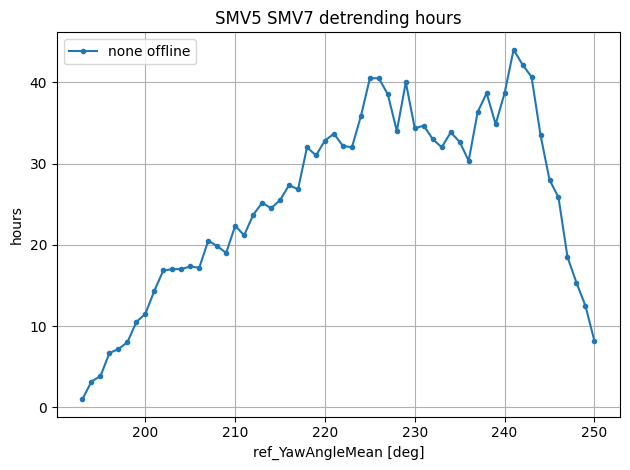

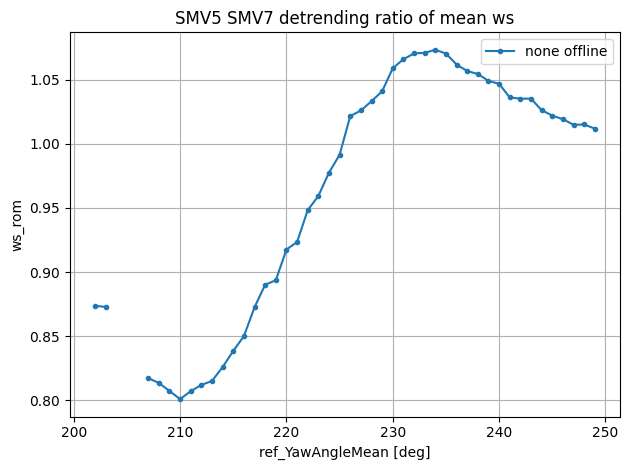

SMV7 Ops Curve Shift warning: abs(CurveTypes.PITCH) > 0.1: 0.223

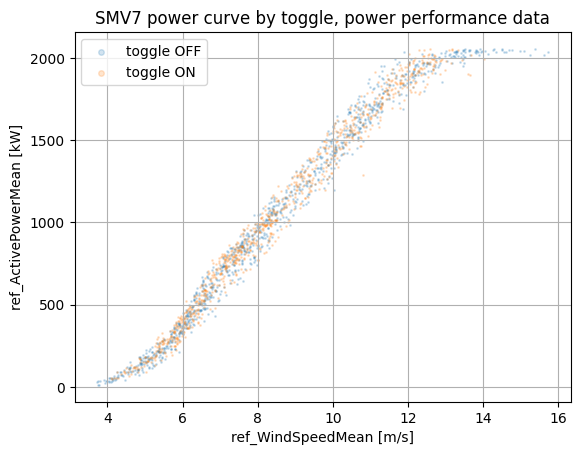

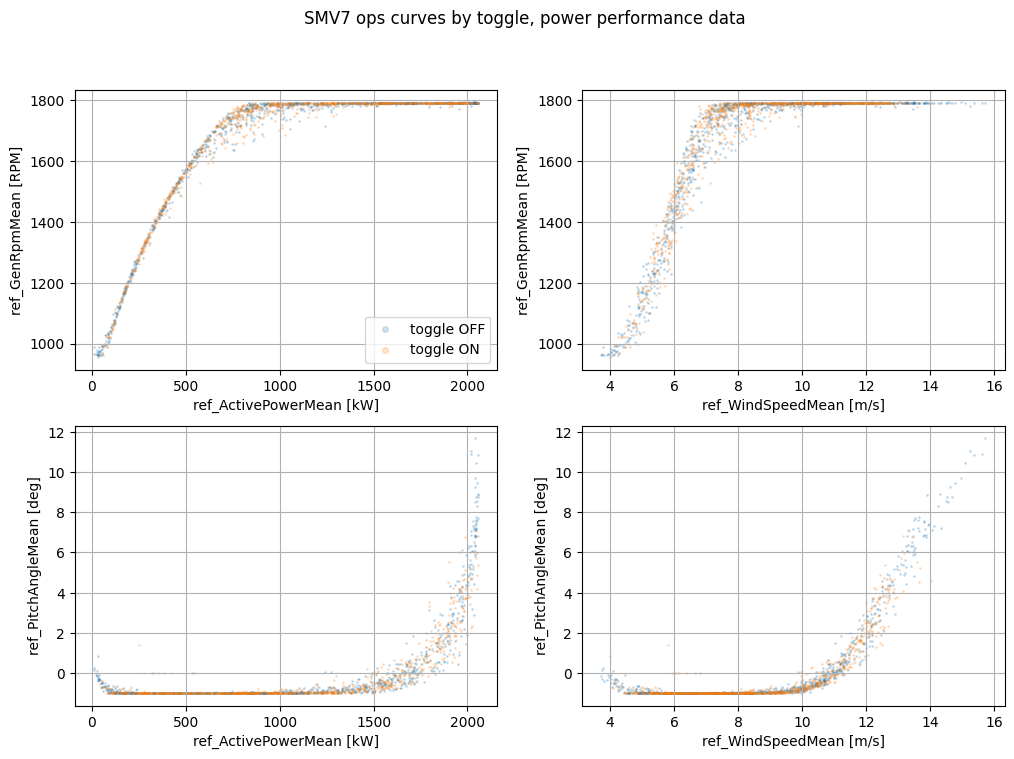

top 5 SMV5 SMV7 waking scenarios [%]:

+-------------------+------+<br>| none offline      | 86.5 |<br>| SMV6 SMV7 offline |  5.3 |<br>| SMV6 offline      |  4.1 |<br>| unknown           |  4.1 |<br>| SMV7 offline      |  0.1 |<br>+-------------------+------+

top 2 SMV5 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 97.6 |<br>| unknown      |  2.4 |<br>+--------------+------+

detrend applied to 65 scenario - directions

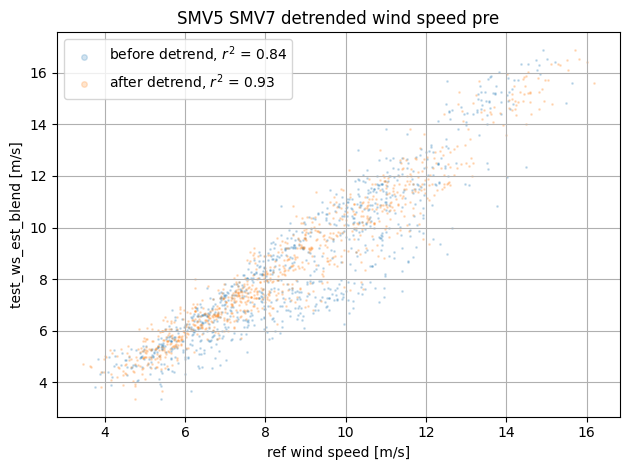

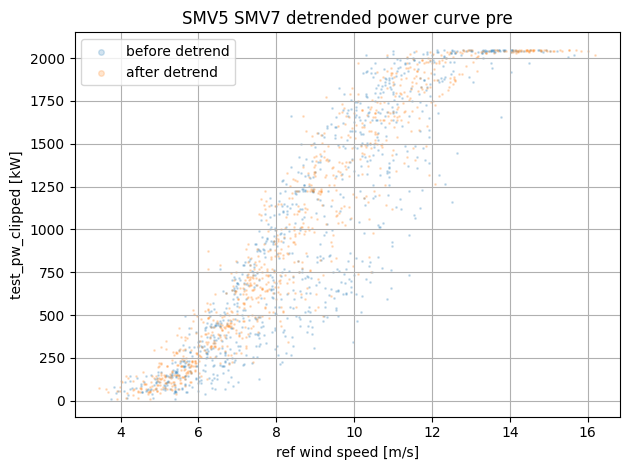

detrend applied to 58 scenario - directions

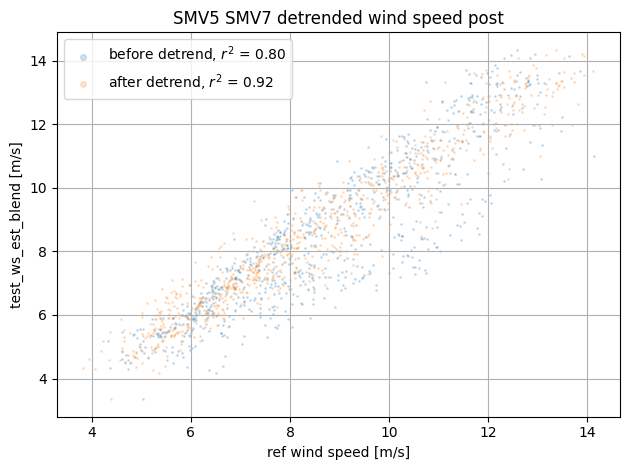

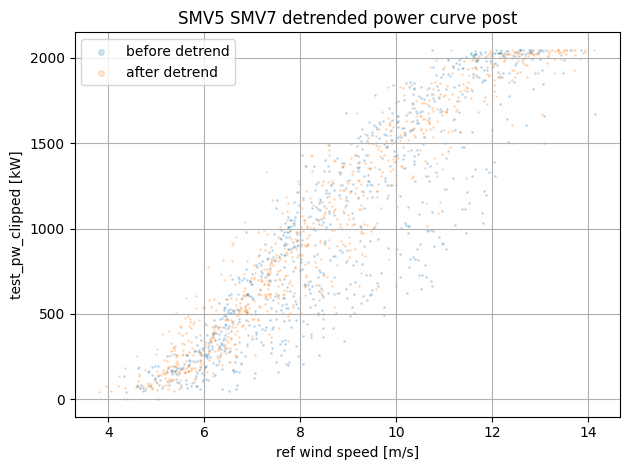

detrend improved pre_df ws r2 by 0.10 (0.84 to 0.93)

detrend improved post_df ws r2 by 0.12 (0.80 to 0.92)

removed 0 bad detrend results

removed 0 bad detrend results

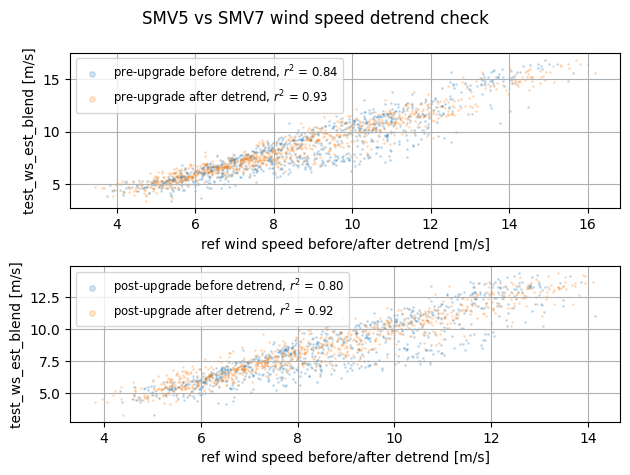

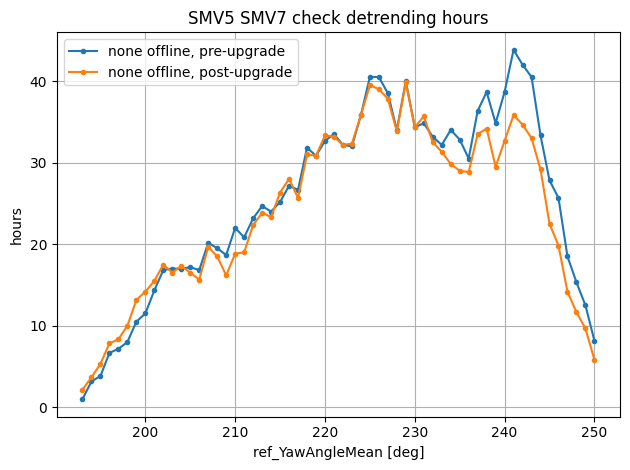

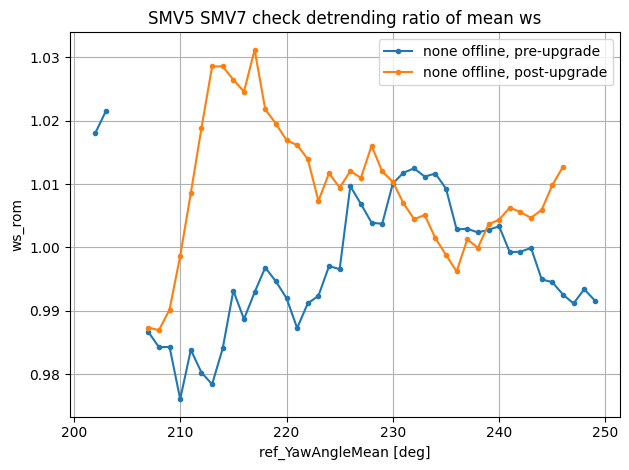

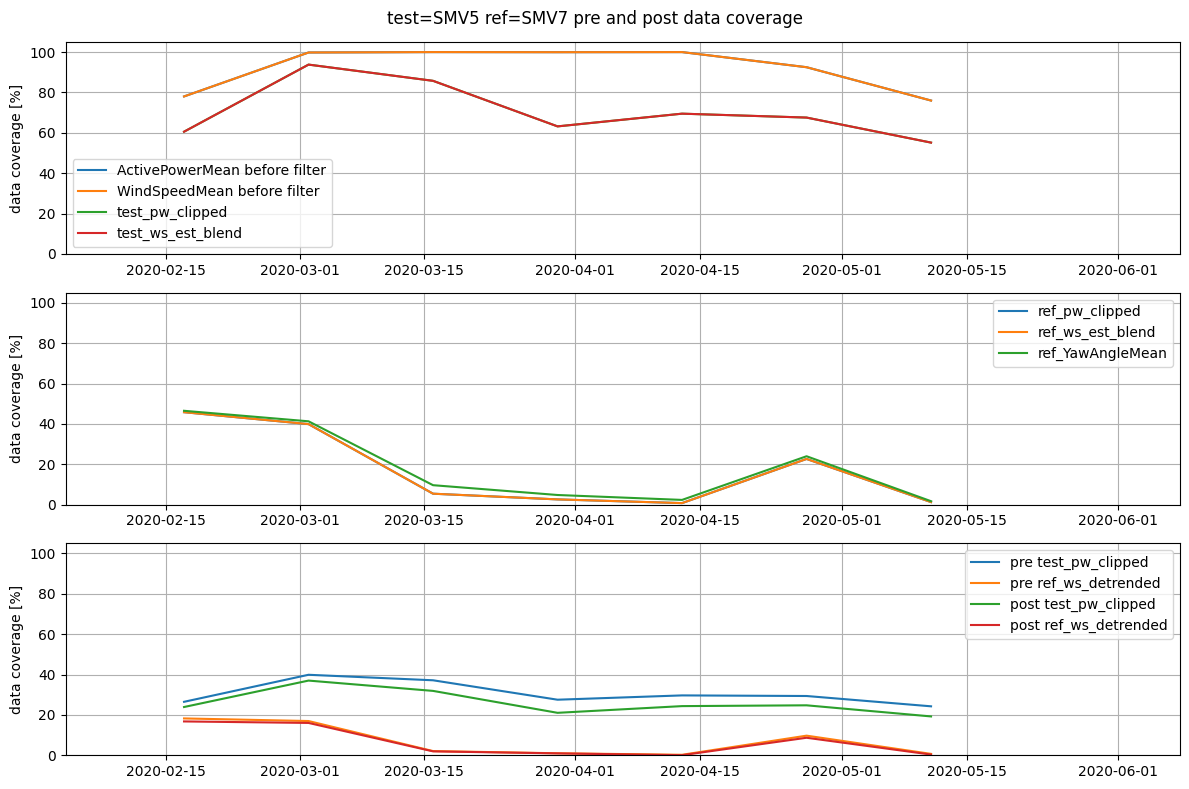

removed 71 [7.8%] rows from pre_df using any_within_timedelta pairing filter

removed 12 [1.4%] rows from post_df using any_within_timedelta pairing filter

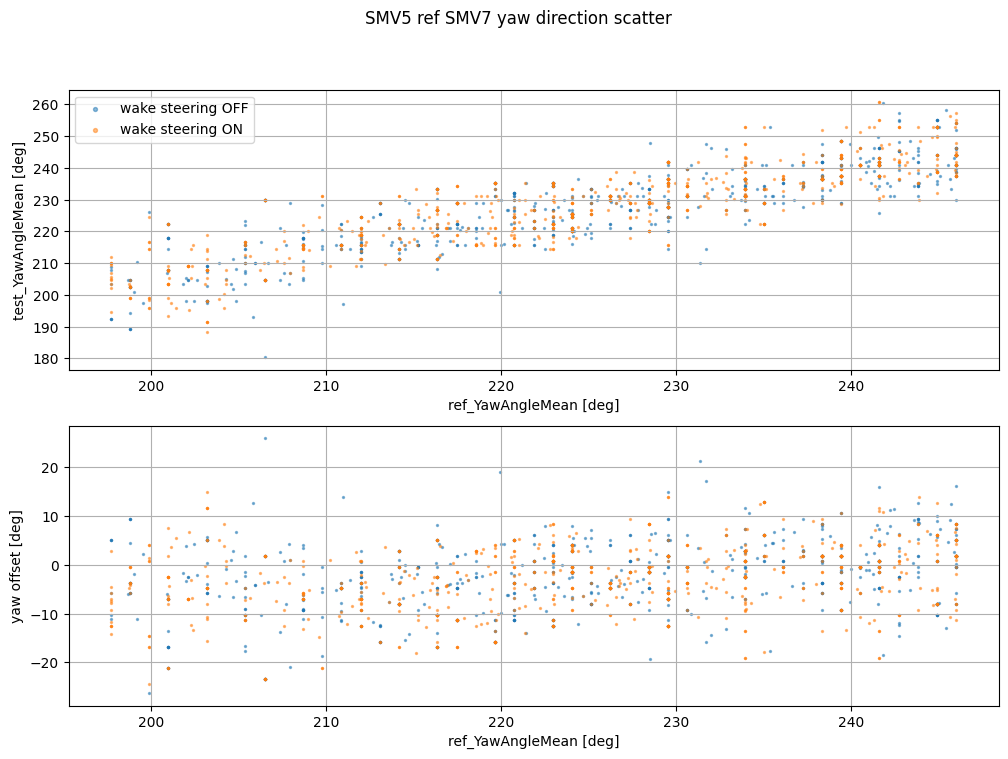

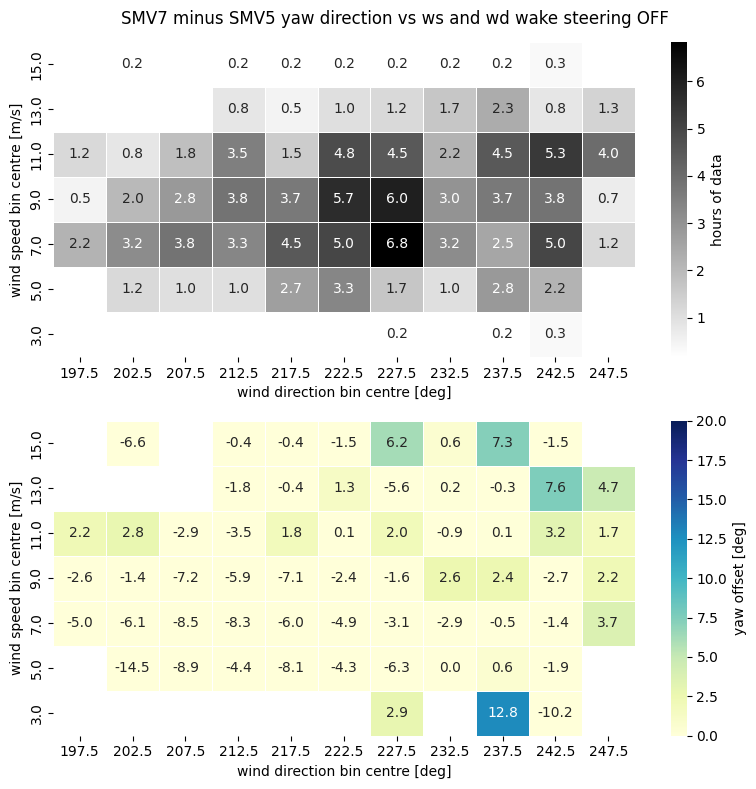

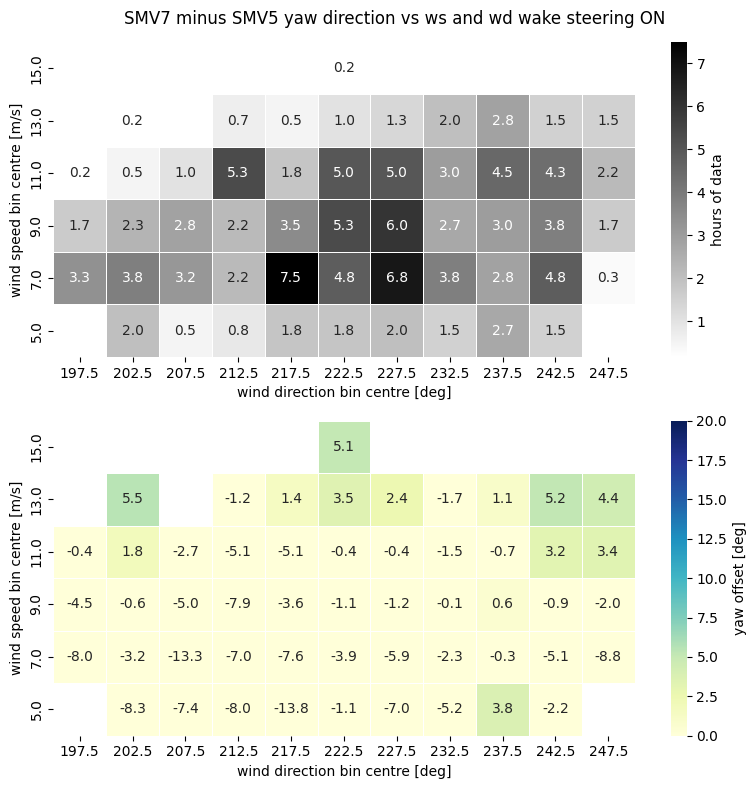

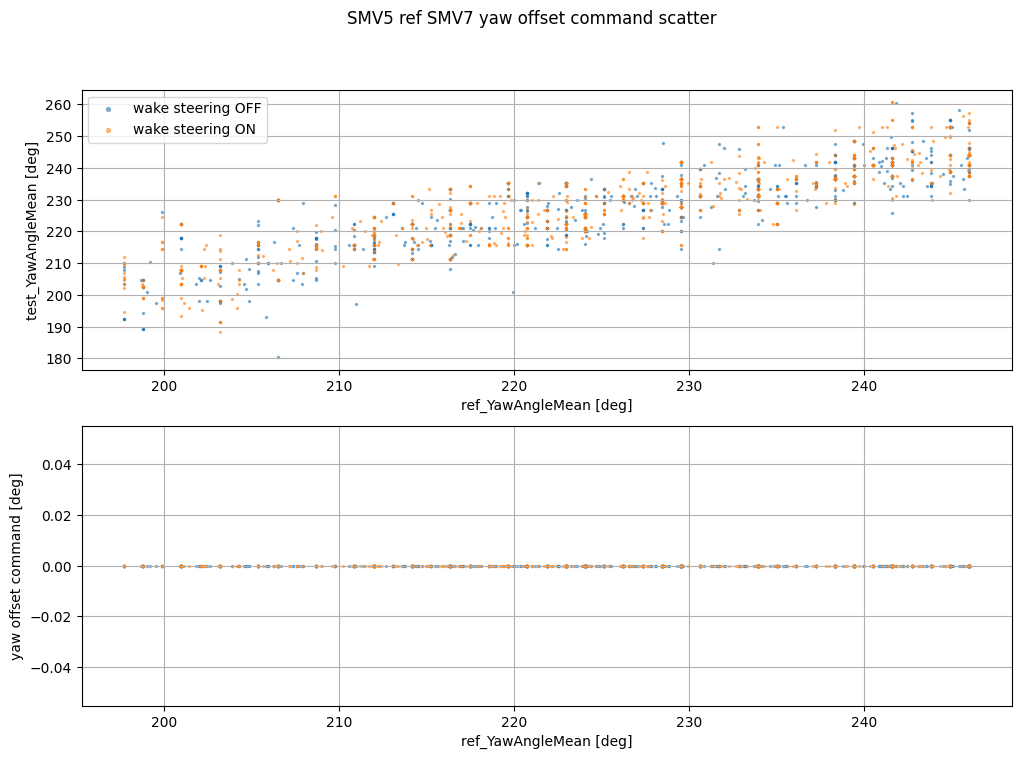

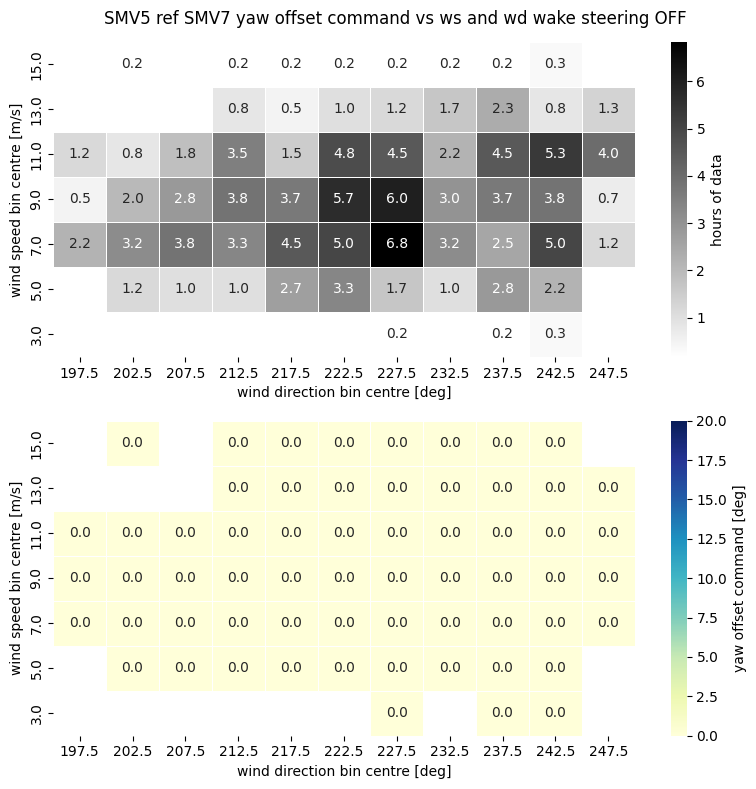

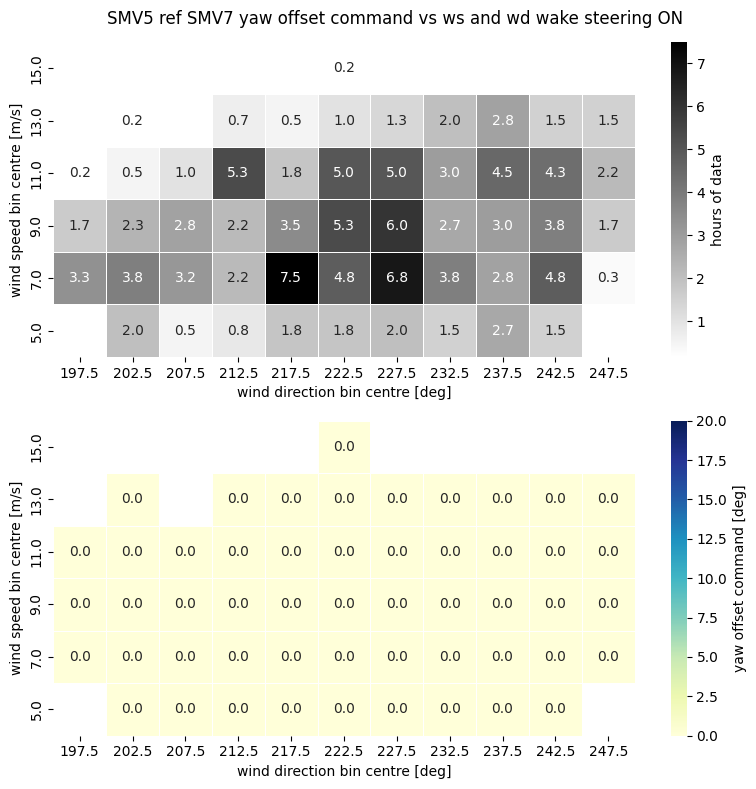

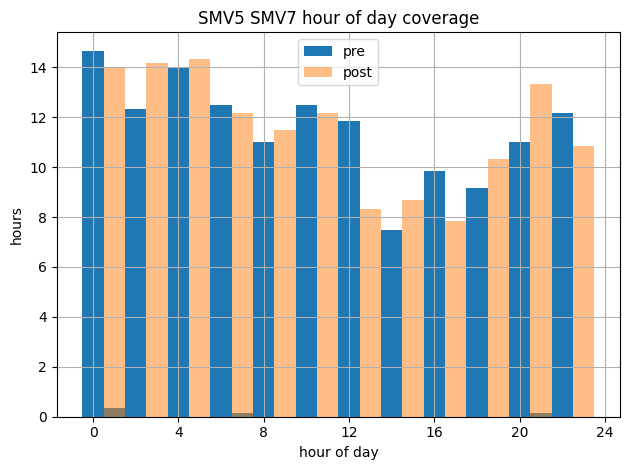

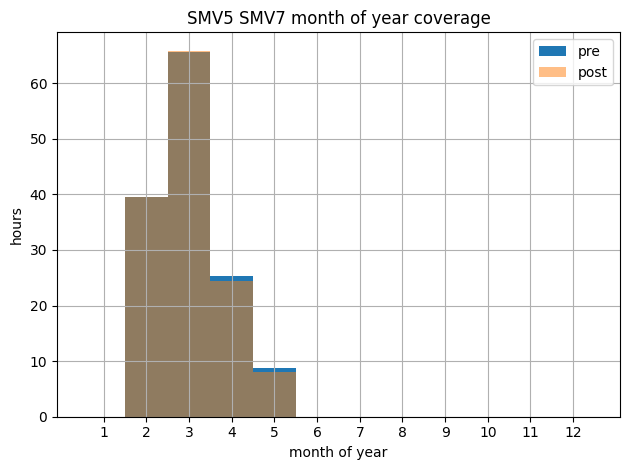

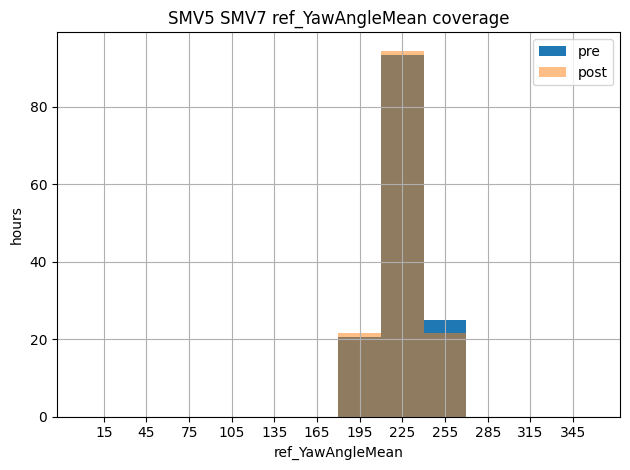

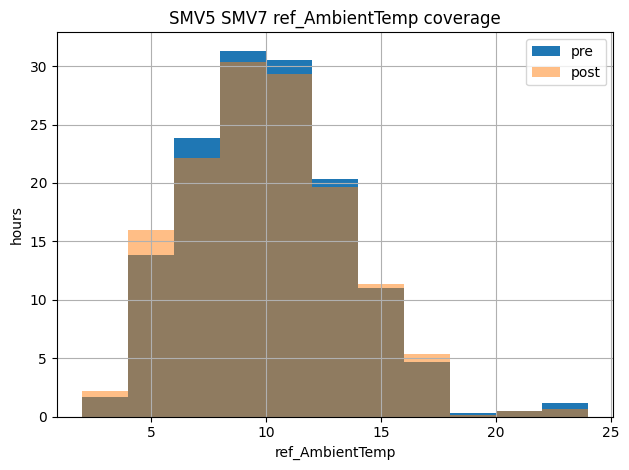

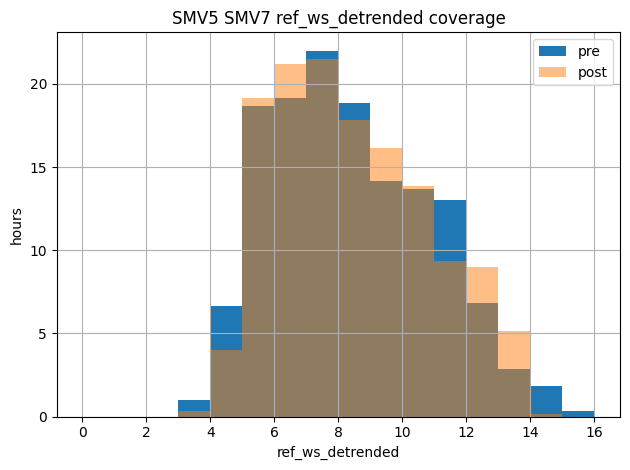

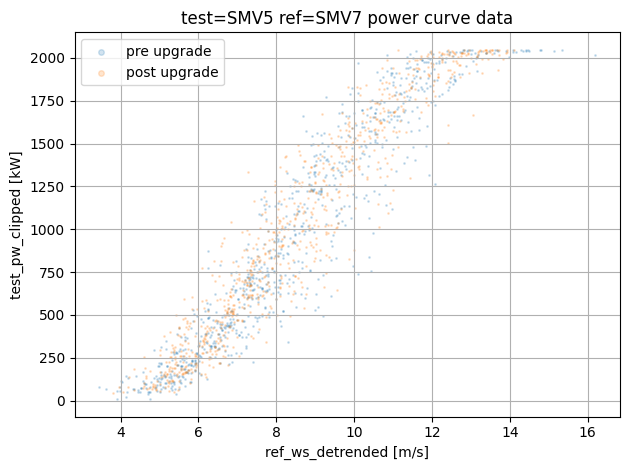

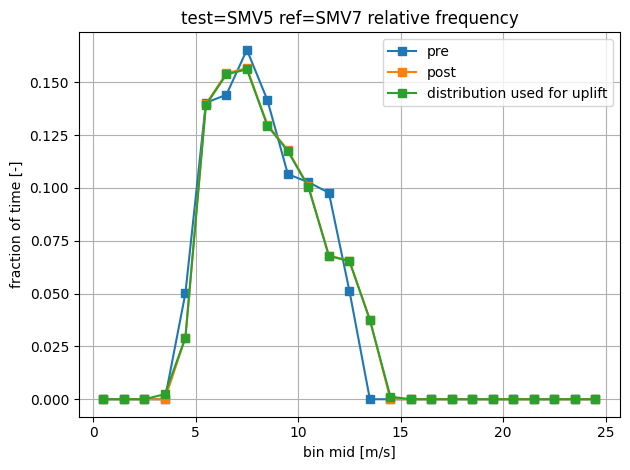

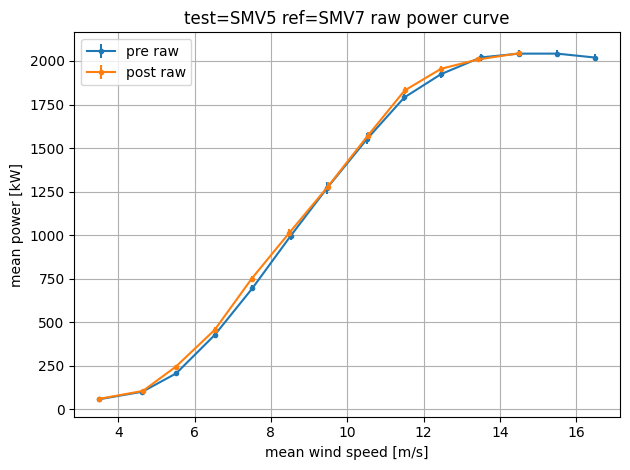

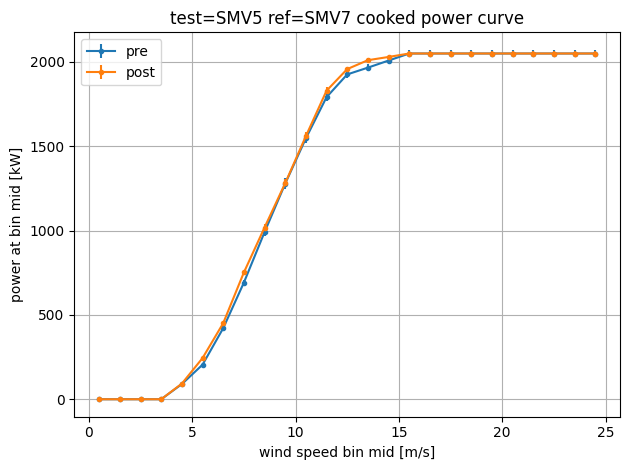

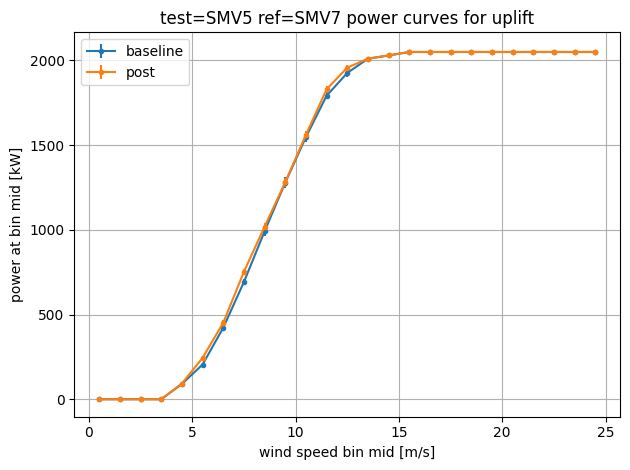

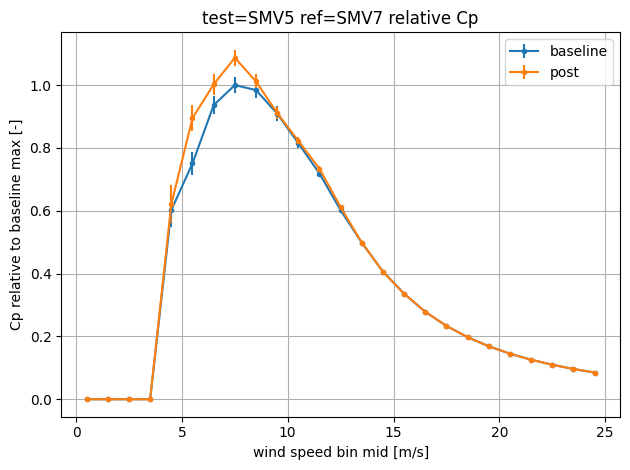

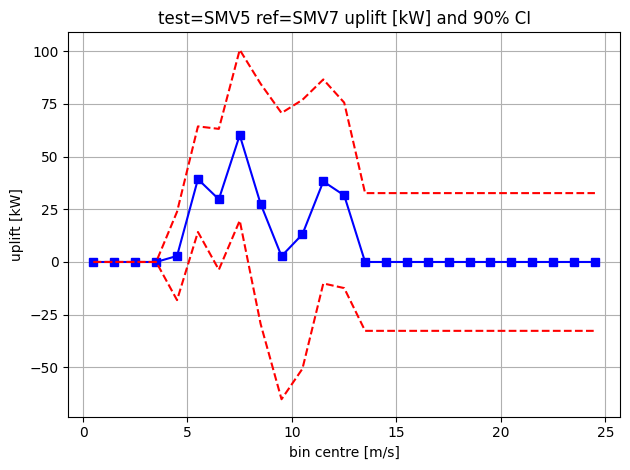

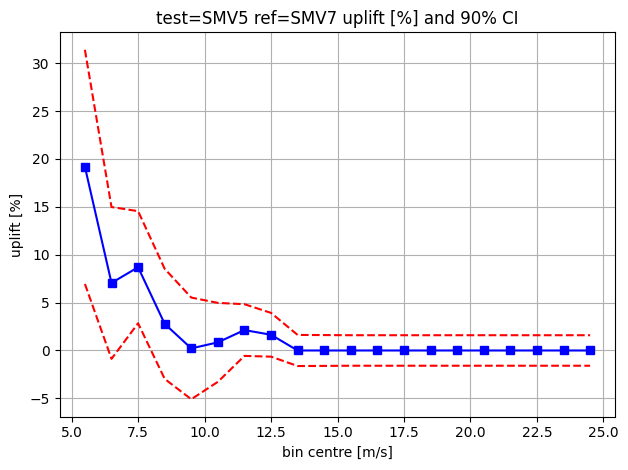

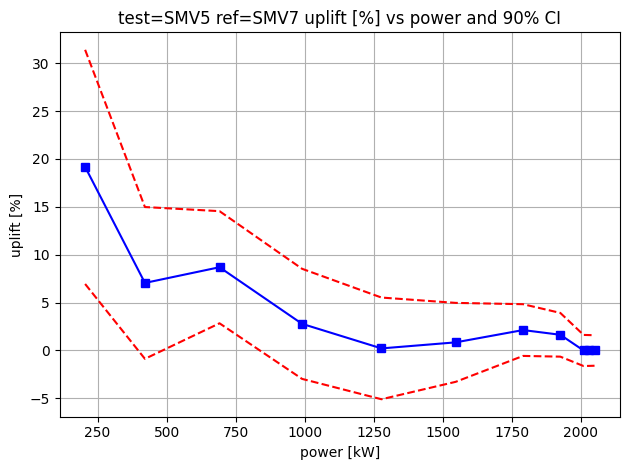

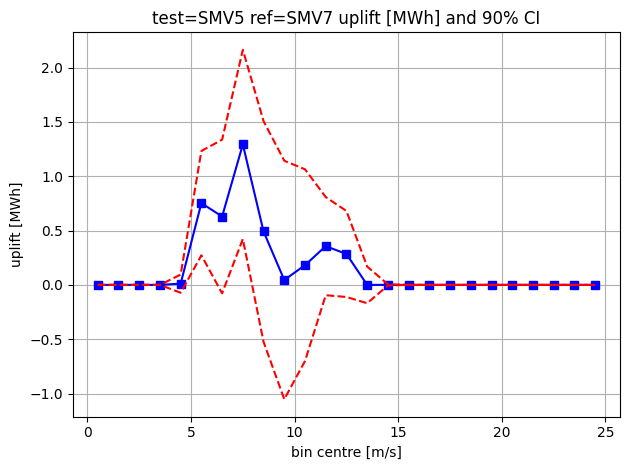

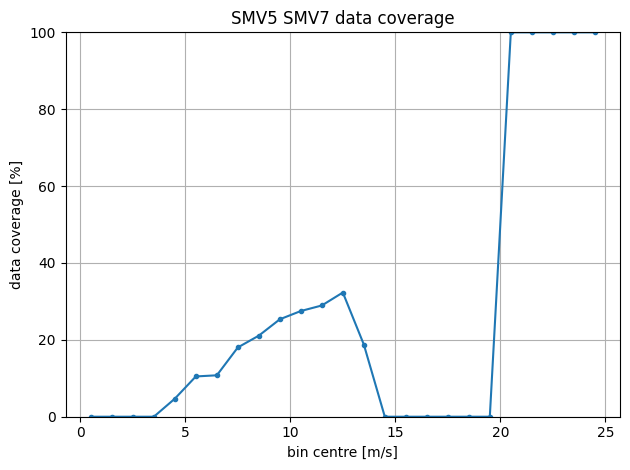

<br>results for test=SMV5 ref=SMV7:<br>

hours pre = 133.0

hours post = 137.2

<br>uplift estimate before adjustments = 3.1 %

<br>power only uplift estimate = 3.0 %

reversed (power only) uplift estimate = 3.1 %<br>

Running block bootstrapping uncertainty analysis n_samples = 400

  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):<br>  median = 3.1 %<br>  lower = 1.3 %<br>  upper = 5.1 %<br>  unc_one_sigma = 1.2 %

<br>cat A 1 sigma unc = 1.0 %

abs reversal error / 2 = 0.037 %

bootstrap 1 sigma unc = 1.2 %

missing bins scale factor = 1.000

final 1 sigma unc = 1.2 %<br>

final uplift estimate = 3.1 %

final P95 uplift estimate = 1.2 %

final P5 uplift estimate = 5.0 %

{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 591.1178519927024, 'bearing_deg': 190.23567745705736, 'ref_max_northing_error_v_reanalysis': np.float64(2.6590754551807976), 'ref_max_northing_error_v_wf': np.float64(2.842170943040401e-14), 'ref_max_ws_drift': np.float64(0.08697706942338845), 'ref_max_ws_drift_pp_period': np.float64(0.08697706942338845), 'ref_powercurve_shift': np.float64(0.003117456887993697), 'ref_rpm_shift': np.float64(0.0015313319638985412), 'ref_pitch_shift': np.float64(0.22323442242659364), 'ref_wind_speed_shift': np.float64(-0.0009576682888782218), 'detrend_pre_r2_improvement': np.float64(0.09621188863947527), 'detrend_post_r2_improvement': np.float64(0.11890364717818414), 'mean_power_pre': np.float64(955.493497245509), 'mean_power_post': np.float64(993.6911992736077), 'mean_test_yaw_offset_pre': np.float64(-2.2725466102034675), 'mean_test_yaw_offset_post': np.float64(-2.876981850327039), 'mean_test_yaw_offset_command_pre': np.float64(0.0), 'mean_test_yaw_offset_command_post': np.float64(0.0), 'mean_ref_yaw_offset_command_pre': np.float64(0.0), 'test_ref_warning_counts': 1, 'time_calculated': Timestamp('2024-10-09 11:24:11.864198+0000', tz='UTC'), 'uplift_frc': np.float64(0.030879346731271313), 'unc_one_sigma_frc': np.float64(0.01167847006525424), 't_value_one_sigma': np.float64(1.0006277462668354), 'missing_bins_unc_scale_factor': 1, 'pp_valid_hours_pre': np.float64(133.0), 'pp_valid_hours_post': np.float64(137.16666666666669), 'pp_valid_hours': np.float64(270.1666666666667), 'pp_data_coverage': np.float64(0.11567829872261472), 'pp_invalid_bin_count': np.int64(16), 'uplift_noadj_frc': np.float64(0.030509447623790466), 'unc_one_sigma_noadj_frc': np.float64(0.01004760180633488), 'poweronly_uplift_frc': np.float64(0.029990866525649328), 'reversed_uplift_frc': np.float64(0.03073066474061102), 'reversal_error': np.float64(0.0007397982149616941), 'unc_one_sigma_lowerbound_frc': np.float64(0.00036989910748084706), 'unc_one_sigma_bootstrap_frc': np.float64(0.01167847006525424), 'uplift_p5_frc': np.float64(0.050088720575348945), 'uplift_p95_frc': np.float64(0.01166997288719368), 'wind_up_version': '0.1.9', 'test_wtg': 'SMV5', 'test_pw_col': 'test_pw_clipped', 'lt_wtg_hours_raw': 0, 'lt_wtg_hours_filt': 0, 'test_max_ws_drift': np.float64(0.10726609831004863), 'test_max_ws_drift_pp_period': np.float64(0.10726609831004863), 'test_powercurve_shift': np.float64(-0.005678000921447213), 'test_rpm_shift': np.float64(0.0013951853610039144), 'test_pitch_shift': np.float64(0.0708669977507359), 'test_wind_speed_shift': np.float64(-0.003676810002385955), 'preprocess_warning_counts': 0, 'test_warning_counts': 0}

warning summary: preprocess_warning_counts=0, test_warning_counts=0, test_ref_warning_counts=1

finished analysing SMV5 SMV7<br>

In [12]:
results_per_test_ref_df = run_wind_up_analysis(assessment_inputs)

## print the per turbine results as a nice table

In [13]:
from examples.smarteole_example import print_smarteole_results

print_smarteole_results(results_per_test_ref_df, print_small_table=True, check_results=True)

+-----------+-------------+-----------------+--------------+-------------+-------------------------+
|  turbine  |  reference  |  energy uplift  |  uplift P95  |  uplift P5  |  valid hours toggle on  |
+===========+=============+=================+==============+=============+=========================+
|   SMV6    |    SMV7     |      -1.0%      |    -2.0%     |    -0.1%    |          136.0          |
|   SMV5    |    SMV7     |      3.1%       |     1.2%     |    5.0%     |          137.2          |
+-----------+-------------+-----------------+--------------+-------------+-------------------------+


## calculate the net uplift of this wake steering test

For wake steering we expect the steering turbine uplift to be negative and the benefitting turbine uplift to be positive (which are both true in this example). The steering turbine will almost always be more productive than the benefitting turbine since it is usually in a windier (un-waked) location, therefore the % uplift of the benefitting turbine needs to be much higher than the % loss of the steering turbine for the net uplift to be positive. The function below properly calculates the net uplift and combined uncertainty.

In [14]:
from wind_up.combine_results import calc_net_uplift

net_p50, net_p95, net_p5 = calc_net_uplift(results_per_test_ref_df, confidence=0.9)
print(f"net P50: {net_p50:.1%}, net P95: {net_p95:.1%}, net P5: {net_p5:.1%}")  # noqa T201

net P50: 0.8%, net P95: -0.2%, net P5: 1.9%
